In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = pd.read_csv('train_trans.csv')
y_train = X_train['FLAG']
X_val = pd.read_csv('val_trans.csv')
y_val = X_val['FLAG']
X_test = pd.read_csv('test_trans.csv')
y_test = X_test['FLAG']

In [3]:
X_train.drop(columns=['Unnamed: 0','FLAG'], inplace = True) # drop the first two columns
X_val.drop(columns=['Unnamed: 0','FLAG'], inplace = True)
X_test.drop(columns=['Unnamed: 0','FLAG'], inplace = True)

Generate Validation Set from X_train

In [4]:
def model_eval(true, predicted):
    tn, fp, fn, tp = confusion_matrix(true,predicted).ravel()
    print(confusion_matrix(true,predicted))
    print('tn = ' + str(tn), 'fp = ' + str(fp),'fn = ' + str(fn),'tp = ' + str(tp))
    print(classification_report(true,predicted))


In [47]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, recall_score

## XGBoost Testing

In [6]:
from xgboost import XGBClassifier

In [9]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
train_pred = xgb.predict(X_train)
model_eval(y_train, train_pred)

[[6205    0]
 [   0 1765]]
tn = 6205 fp = 0 fn = 0 tp = 1765
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6205
           1       1.00      1.00      1.00      1765

    accuracy                           1.00      7970
   macro avg       1.00      1.00      1.00      7970
weighted avg       1.00      1.00      1.00      7970



In [10]:
val_pred = xgb.predict(X_val)
model_eval(val_pred, y_val)

[[683   7]
 [  7 189]]
tn = 683 fp = 7 fn = 7 tp = 189
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       690
           1       0.96      0.96      0.96       196

    accuracy                           0.98       886
   macro avg       0.98      0.98      0.98       886
weighted avg       0.98      0.98      0.98       886



## Hyperparameter Tuning

In [35]:
%%time
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
space={'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'gamma': hp.uniform ('gamma', 0,9),
        'reg_alpha' : hp.quniform('reg_alpha', 0,140,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.randint('n_estimators', 180)
    }


CPU times: total: 0 ns
Wall time: 0 ns


In [68]:
%%time
def objective(space):
    xgb = XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']),reg_lambda = space['reg_lambda'], early_stopping_rounds = 10)
    xgb.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric='auc')
    pred = xgb.predict(X_val)
    accuracy = f1_score(y_val, pred)
    return{'loss':-accuracy, 'status': STATUS_OK}

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
%%time
trials = Trials()
best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 300,
                        trials = trials)

[0]	validation_0-auc:0.77845                                                                                           
[1]	validation_0-auc:0.77845                                                                                           
[2]	validation_0-auc:0.85484                                                                                           
[3]	validation_0-auc:0.85484                                                                                           
[4]	validation_0-auc:0.85484                                                                                           
[5]	validation_0-auc:0.92001                                                                                           
[6]	validation_0-auc:0.92001                                                                                           
[7]	validation_0-auc:0.92001                                                                                           
[8]	validation_0-auc:0.92755            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98121                                                                                          
[20]	validation_0-auc:0.98121                                                                                          
[21]	validation_0-auc:0.98121                                                                                          
[22]	validation_0-auc:0.98576                                                                                          
[23]	validation_0-auc:0.98570                                                                                          
[24]	validation_0-auc:0.98570                                                                                          
[25]	validation_0-auc:0.98570                                                                                          
[26]	validation_0-auc:0.98700                                                                                          
[27]	validation_0-auc:0.98700           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98966                                                                                          
[22]	validation_0-auc:0.99423                                                                                          
[23]	validation_0-auc:0.99460                                                                                          
[24]	validation_0-auc:0.99460                                                                                          
[25]	validation_0-auc:0.99460                                                                                          
[26]	validation_0-auc:0.99429                                                                                          
[27]	validation_0-auc:0.99429                                                                                          
[28]	validation_0-auc:0.99516                                                                                          
[29]	validation_0-auc:0.99470           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98334                                                                                          
[19]	validation_0-auc:0.98334                                                                                          
[20]	validation_0-auc:0.98334                                                                                          
[21]	validation_0-auc:0.98334                                                                                          
[22]	validation_0-auc:0.98926                                                                                          
[23]	validation_0-auc:0.99033                                                                                          
[24]	validation_0-auc:0.99033                                                                                          
[25]	validation_0-auc:0.99033                                                                                          
[26]	validation_0-auc:0.99040           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98557
[19]	validation_0-auc:0.98557                                                                                          
[20]	validation_0-auc:0.98557                                                                                          
[21]	validation_0-auc:0.98557                                                                                          
[22]	validation_0-auc:0.99103                                                                                          
[23]	validation_0-auc:0.99191                                                                                          
[24]	validation_0-auc:0.99191                                                                                          
[25]	validation_0-auc:0.99191                                                                                          
[26]	validation_0-auc:0.99211                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96981
[16]	validation_0-auc:0.96987                                                                                          
[17]	validation_0-auc:0.97944                                                                                          
[18]	validation_0-auc:0.98120                                                                                          
[19]	validation_0-auc:0.98120                                                                                          
[20]	validation_0-auc:0.98120                                                                                          
[21]	validation_0-auc:0.98120                                                                                          
[22]	validation_0-auc:0.98537                                                                                          
[23]	validation_0-auc:0.98529                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98146                                                                                          
[19]	validation_0-auc:0.98146                                                                                          
[20]	validation_0-auc:0.98146                                                                                          
[21]	validation_0-auc:0.98146                                                                                          
[22]	validation_0-auc:0.98573                                                                                          
[23]	validation_0-auc:0.98566                                                                                          
[24]	validation_0-auc:0.98566                                                                                          
[25]	validation_0-auc:0.98566                                                                                          
[26]	validation_0-auc:0.98691           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98182                                                                                          
[19]	validation_0-auc:0.98182                                                                                          
[20]	validation_0-auc:0.98182                                                                                          
[21]	validation_0-auc:0.98182                                                                                          
[22]	validation_0-auc:0.98858                                                                                          
[23]	validation_0-auc:0.98963                                                                                          
[24]	validation_0-auc:0.98963                                                                                          
[25]	validation_0-auc:0.98963                                                                                          
[26]	validation_0-auc:0.99079           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96008
[15]	validation_0-auc:0.97177                                                                                          
[16]	validation_0-auc:0.97175                                                                                          
[17]	validation_0-auc:0.98105                                                                                          
[18]	validation_0-auc:0.98154                                                                                          
[19]	validation_0-auc:0.98154                                                                                          
[20]	validation_0-auc:0.98154                                                                                          
[21]	validation_0-auc:0.98154                                                                                          
[22]	validation_0-auc:0.98506                                                                                          
[23]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.95318                                                                                          
[13]	validation_0-auc:0.95318                                                                                          
[14]	validation_0-auc:0.95728                                                                                          
[15]	validation_0-auc:0.96866                                                                                          
[16]	validation_0-auc:0.96867                                                                                          
[17]	validation_0-auc:0.97913                                                                                          
[18]	validation_0-auc:0.98121                                                                                          
[19]	validation_0-auc:0.98121                                                                                          
[20]	validation_0-auc:0.98121           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97566
[17]	validation_0-auc:0.98217                                                                                          
[18]	validation_0-auc:0.98444                                                                                          
[19]	validation_0-auc:0.98444                                                                                          
[20]	validation_0-auc:0.98444                                                                                          
[21]	validation_0-auc:0.98444                                                                                          
[22]	validation_0-auc:0.98988                                                                                          
[23]	validation_0-auc:0.99059                                                                                          
[24]	validation_0-auc:0.99059                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97931                                                                                          
[18]	validation_0-auc:0.98140                                                                                          
[19]	validation_0-auc:0.98140                                                                                          
[20]	validation_0-auc:0.98140                                                                                          
[21]	validation_0-auc:0.98140                                                                                          
[22]	validation_0-auc:0.98566                                                                                          
[23]	validation_0-auc:0.98554                                                                                          
[24]	validation_0-auc:0.98554                                                                                          
[25]	validation_0-auc:0.98554           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97154                                                                                          
[16]	validation_0-auc:0.97165                                                                                          
[17]	validation_0-auc:0.98028                                                                                          
[18]	validation_0-auc:0.98299                                                                                          
[19]	validation_0-auc:0.98299                                                                                          
[20]	validation_0-auc:0.98299                                                                                          
[21]	validation_0-auc:0.98299                                                                                          
[22]	validation_0-auc:0.98928                                                                                          
[23]	validation_0-auc:0.99041           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98156                                                                                          
[19]	validation_0-auc:0.98156                                                                                          
[20]	validation_0-auc:0.98156                                                                                          
[21]	validation_0-auc:0.98156                                                                                          
[22]	validation_0-auc:0.98487                                                                                          
[23]	validation_0-auc:0.98479                                                                                          
[24]	validation_0-auc:0.98479                                                                                          
[25]	validation_0-auc:0.98479                                                                                          
[26]	validation_0-auc:0.98618           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.95914                                                                                          
[15]	validation_0-auc:0.97095                                                                                          
[16]	validation_0-auc:0.97113                                                                                          
[17]	validation_0-auc:0.98072                                                                                          
[18]	validation_0-auc:0.98169                                                                                          
[19]	validation_0-auc:0.98169                                                                                          
[20]	validation_0-auc:0.98169                                                                                          
[21]	validation_0-auc:0.98169                                                                                          
[22]	validation_0-auc:0.98555           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97953                                                                                          
[18]	validation_0-auc:0.98123                                                                                          
[19]	validation_0-auc:0.98123                                                                                          
[20]	validation_0-auc:0.98123                                                                                          
[21]	validation_0-auc:0.98123                                                                                          
[22]	validation_0-auc:0.98566                                                                                          
[23]	validation_0-auc:0.98561                                                                                          
[24]	validation_0-auc:0.98561                                                                                          
[25]	validation_0-auc:0.98561           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98123                                                                                          
[18]	validation_0-auc:0.98370                                                                                          
[19]	validation_0-auc:0.98370                                                                                          
[20]	validation_0-auc:0.98370                                                                                          
[21]	validation_0-auc:0.98370                                                                                          
[22]	validation_0-auc:0.98966                                                                                          
[23]	validation_0-auc:0.99074                                                                                          
[24]	validation_0-auc:0.99074                                                                                          
[25]	validation_0-auc:0.99074           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98269                                                                                          
[19]	validation_0-auc:0.98269                                                                                          
[20]	validation_0-auc:0.98269                                                                                          
[21]	validation_0-auc:0.98269                                                                                          
[22]	validation_0-auc:0.98821                                                                                          
[23]	validation_0-auc:0.98929                                                                                          
[24]	validation_0-auc:0.98929                                                                                          
[25]	validation_0-auc:0.98929                                                                                          
[26]	validation_0-auc:0.98974           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.96359                                                                                          
[14]	validation_0-auc:0.96622                                                                                          
[15]	validation_0-auc:0.97945                                                                                          
[16]	validation_0-auc:0.97939                                                                                          
[17]	validation_0-auc:0.98434                                                                                          
[18]	validation_0-auc:0.98661                                                                                          
[19]	validation_0-auc:0.98661                                                                                          
[20]	validation_0-auc:0.98661                                                                                          
[21]	validation_0-auc:0.98661           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97914
[18]	validation_0-auc:0.98124                                                                                          
[19]	validation_0-auc:0.98124                                                                                          
[20]	validation_0-auc:0.98124                                                                                          
[21]	validation_0-auc:0.98124                                                                                          
[22]	validation_0-auc:0.98633                                                                                          
[23]	validation_0-auc:0.98637                                                                                          
[24]	validation_0-auc:0.98637                                                                                          
[25]	validation_0-auc:0.98637                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96965                                                                                          
[16]	validation_0-auc:0.96962                                                                                          
[17]	validation_0-auc:0.97956                                                                                          
[18]	validation_0-auc:0.98142                                                                                          
[19]	validation_0-auc:0.98142                                                                                          
[20]	validation_0-auc:0.98142                                                                                          
[21]	validation_0-auc:0.98142                                                                                          
[22]	validation_0-auc:0.98461                                                                                          
[23]	validation_0-auc:0.98467           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98888                                                                                          
[19]	validation_0-auc:0.98888                                                                                          
[20]	validation_0-auc:0.98888                                                                                          
[21]	validation_0-auc:0.98888                                                                                          
[22]	validation_0-auc:0.99373                                                                                          
[23]	validation_0-auc:0.99479                                                                                          
[24]	validation_0-auc:0.99479                                                                                          
[25]	validation_0-auc:0.99479                                                                                          
[26]	validation_0-auc:0.99453           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98206                                                                                          
[17]	validation_0-auc:0.98594                                                                                          
[18]	validation_0-auc:0.98841                                                                                          
[19]	validation_0-auc:0.98841                                                                                          
[20]	validation_0-auc:0.98841                                                                                          
[21]	validation_0-auc:0.98841                                                                                          
[22]	validation_0-auc:0.99337                                                                                          
[23]	validation_0-auc:0.99396                                                                                          
[24]	validation_0-auc:0.99396           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97756                                                                                          
[16]	validation_0-auc:0.97751                                                                                          
[17]	validation_0-auc:0.98226                                                                                          
[18]	validation_0-auc:0.98449                                                                                          
[19]	validation_0-auc:0.98449                                                                                          
[20]	validation_0-auc:0.98449                                                                                          
[21]	validation_0-auc:0.98449                                                                                          
[22]	validation_0-auc:0.99048                                                                                          
[23]	validation_0-auc:0.99142           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98258                                                                                          
[16]	validation_0-auc:0.98253                                                                                          
[17]	validation_0-auc:0.98671                                                                                          
[18]	validation_0-auc:0.98938                                                                                          
[19]	validation_0-auc:0.98938                                                                                          
[20]	validation_0-auc:0.98938                                                                                          
[21]	validation_0-auc:0.98938                                                                                          
[22]	validation_0-auc:0.99365                                                                                          
[23]	validation_0-auc:0.99469           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97209                                                                                          
[16]	validation_0-auc:0.97221                                                                                          
[17]	validation_0-auc:0.98039                                                                                          
[18]	validation_0-auc:0.98269                                                                                          
[19]	validation_0-auc:0.98269                                                                                          
[20]	validation_0-auc:0.98269                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87966            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97751
[16]	validation_0-auc:0.97745                                                                                          
[17]	validation_0-auc:0.98213                                                                                          
[18]	validation_0-auc:0.98441                                                                                          
[19]	validation_0-auc:0.98441                                                                                          
[20]	validation_0-auc:0.98441                                                                                          
[21]	validation_0-auc:0.98441                                                                                          
[22]	validation_0-auc:0.99042                                                                                          
[23]	validation_0-auc:0.99141                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96212
[15]	validation_0-auc:0.97269                                                                                          
[16]	validation_0-auc:0.97281                                                                                          
[17]	validation_0-auc:0.98083                                                                                          
[18]	validation_0-auc:0.98339                                                                                          
[19]	validation_0-auc:0.98339                                                                                          
[20]	validation_0-auc:0.98339                                                                                          
[21]	validation_0-auc:0.98339                                                                                          
[22]	validation_0-auc:0.98919                                                                                          
[23]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97784                                                                                          
[17]	validation_0-auc:0.98463                                                                                          
[18]	validation_0-auc:0.98832                                                                                          
[19]	validation_0-auc:0.98832                                                                                          
[20]	validation_0-auc:0.98828                                                                                          
[21]	validation_0-auc:0.98828                                                                                          
[22]	validation_0-auc:0.99254                                                                                          
[23]	validation_0-auc:0.99378                                                                                          
[24]	validation_0-auc:0.99378           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97811                                                                                          
[17]	validation_0-auc:0.98282                                                                                          
[18]	validation_0-auc:0.98476                                                                                          
[19]	validation_0-auc:0.98476                                                                                          
[20]	validation_0-auc:0.98476                                                                                          
[21]	validation_0-auc:0.98476                                                                                          
[22]	validation_0-auc:0.99066                                                                                          
[23]	validation_0-auc:0.99166                                                                                          
[24]	validation_0-auc:0.99166           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97394                                                                                          
[17]	validation_0-auc:0.97990                                                                                          
[18]	validation_0-auc:0.98265                                                                                          
[19]	validation_0-auc:0.98265                                                                                          
[20]	validation_0-auc:0.98265                                                                                          
[21]	validation_0-auc:0.98265                                                                                          
[22]	validation_0-auc:0.98873                                                                                          
[23]	validation_0-auc:0.98963                                                                                          
[24]	validation_0-auc:0.98963           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98046
[18]	validation_0-auc:0.98312                                                                                          
[19]	validation_0-auc:0.98312                                                                                          
[20]	validation_0-auc:0.98312                                                                                          
[21]	validation_0-auc:0.98312                                                                                          
[22]	validation_0-auc:0.98882                                                                                          
[23]	validation_0-auc:0.98966                                                                                          
[24]	validation_0-auc:0.98966                                                                                          
[25]	validation_0-auc:0.98966                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96236                                                                                          
[13]	validation_0-auc:0.96075                                                                                          
[14]	validation_0-auc:0.96355                                                                                          
[15]	validation_0-auc:0.97578                                                                                          
[16]	validation_0-auc:0.97574                                                                                          
[17]	validation_0-auc:0.98322                                                                                          
[18]	validation_0-auc:0.98448                                                                                          
[19]	validation_0-auc:0.98448                                                                                          
[20]	validation_0-auc:0.98448           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96545                                                                                          
[13]	validation_0-auc:0.96340                                                                                          
[14]	validation_0-auc:0.96581                                                                                          
[15]	validation_0-auc:0.98170                                                                                          
[16]	validation_0-auc:0.98164                                                                                          
[17]	validation_0-auc:0.98621                                                                                          
[18]	validation_0-auc:0.98916                                                                                          
[19]	validation_0-auc:0.98916                                                                                          
[20]	validation_0-auc:0.98916           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96879                                                                                          
[16]	validation_0-auc:0.96881                                                                                          
[17]	validation_0-auc:0.97921                                                                                          
[18]	validation_0-auc:0.98124                                                                                          
[19]	validation_0-auc:0.98124                                                                                          
[20]	validation_0-auc:0.98124                                                                                          
[21]	validation_0-auc:0.98124                                                                                          
[22]	validation_0-auc:0.98596                                                                                          
[23]	validation_0-auc:0.98585           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97981                                                                                          
[18]	validation_0-auc:0.98234                                                                                          
[19]	validation_0-auc:0.98234                                                                                          
[20]	validation_0-auc:0.98234                                                                                          
[21]	validation_0-auc:0.98234                                                                                          
[22]	validation_0-auc:0.98858                                                                                          
[23]	validation_0-auc:0.98947                                                                                          
[24]	validation_0-auc:0.98947                                                                                          
[25]	validation_0-auc:0.98947           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97797                                                                                          
[17]	validation_0-auc:0.98361                                                                                          
[18]	validation_0-auc:0.98553                                                                                          
[19]	validation_0-auc:0.98553                                                                                          
[20]	validation_0-auc:0.98553                                                                                          
[21]	validation_0-auc:0.98553                                                                                          
[22]	validation_0-auc:0.99137                                                                                          
[23]	validation_0-auc:0.99225                                                                                          
[24]	validation_0-auc:0.99225           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97375                                                                                          
[16]	validation_0-auc:0.97389                                                                                          
[17]	validation_0-auc:0.98117                                                                                          
[18]	validation_0-auc:0.98366                                                                                          
[19]	validation_0-auc:0.98366                                                                                          
[20]	validation_0-auc:0.98366                                                                                          
[21]	validation_0-auc:0.98366                                                                                          
[22]	validation_0-auc:0.98984                                                                                          
[23]	validation_0-auc:0.99098           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98096                                                                                          
[17]	validation_0-auc:0.98634                                                                                          
[18]	validation_0-auc:0.98850                                                                                          
[19]	validation_0-auc:0.98850                                                                                          
[20]	validation_0-auc:0.98850                                                                                          
[21]	validation_0-auc:0.98850                                                                                          
[22]	validation_0-auc:0.99279                                                                                          
[23]	validation_0-auc:0.99376                                                                                          
[24]	validation_0-auc:0.99376           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98119
[18]	validation_0-auc:0.98352                                                                                          
[19]	validation_0-auc:0.98352                                                                                          
[20]	validation_0-auc:0.98352                                                                                          
[21]	validation_0-auc:0.98352                                                                                          
[22]	validation_0-auc:0.98948                                                                                          
[23]	validation_0-auc:0.99042                                                                                          
[24]	validation_0-auc:0.99042                                                                                          
[25]	validation_0-auc:0.99042                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.78484                                                                                           
[1]	validation_0-auc:0.78484                                                                                           
[2]	validation_0-auc:0.88501                                                                                           
[3]	validation_0-auc:0.88501                                                                                           
[4]	validation_0-auc:0.89217                                                                                           
[5]	validation_0-auc:0.94109                                                                                           
[6]	validation_0-auc:0.94109                                                                                           
[7]	validation_0-auc:0.94109                                                                                           
[8]	validation_0-auc:0.94749            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95560                                                                                          
[14]	validation_0-auc:0.96008                                                                                          
[15]	validation_0-auc:0.97177                                                                                          
[16]	validation_0-auc:0.97175                                                                                          
[17]	validation_0-auc:0.98106                                                                                          
[18]	validation_0-auc:0.98174                                                                                          
[19]	validation_0-auc:0.98174                                                                                          
[20]	validation_0-auc:0.98174                                                                                          
[21]	validation_0-auc:0.98174           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97341                                                                                          
[16]	validation_0-auc:0.97358                                                                                          
[17]	validation_0-auc:0.98123                                                                                          
[18]	validation_0-auc:0.98367                                                                                          
[19]	validation_0-auc:0.98367                                                                                          
[20]	validation_0-auc:0.98367                                                                                          
[21]	validation_0-auc:0.98367                                                                                          
[22]	validation_0-auc:0.98966                                                                                          
[23]	validation_0-auc:0.99081           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95684                                                                                          
[14]	validation_0-auc:0.96066                                                                                          
[15]	validation_0-auc:0.97108                                                                                          
[16]	validation_0-auc:0.97107                                                                                          
[17]	validation_0-auc:0.98051                                                                                          
[18]	validation_0-auc:0.98246                                                                                          
[19]	validation_0-auc:0.98246                                                                                          
[20]	validation_0-auc:0.98246                                                                                          
[21]	validation_0-auc:0.98246           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[8]	validation_0-auc:0.92913                                                                                           
[9]	validation_0-auc:0.92913                                                                                           
[10]	validation_0-auc:0.92913                                                                                          
[11]	validation_0-auc:0.92771                                                                                          
[12]	validation_0-auc:0.95508                                                                                          
[13]	validation_0-auc:0.95508                                                                                          
[14]	validation_0-auc:0.95909                                                                                          
[15]	validation_0-auc:0.96953                                                                                          
[16]	validation_0-auc:0.96957           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97958                                                                                          
[18]	validation_0-auc:0.98204                                                                                          
[19]	validation_0-auc:0.98204                                                                                          
[20]	validation_0-auc:0.98204                                                                                          
[21]	validation_0-auc:0.98204                                                                                          
[22]	validation_0-auc:0.98869                                                                                          
[23]	validation_0-auc:0.98983                                                                                          
[24]	validation_0-auc:0.98983                                                                                          
[25]	validation_0-auc:0.98983           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97849
[16]	validation_0-auc:0.97843                                                                                          
[17]	validation_0-auc:0.98306                                                                                          
[18]	validation_0-auc:0.98515                                                                                          
[19]	validation_0-auc:0.98515                                                                                          
[20]	validation_0-auc:0.98515                                                                                          
[21]	validation_0-auc:0.98515                                                                                          
[22]	validation_0-auc:0.99088                                                                                          
[23]	validation_0-auc:0.99190                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[11]	validation_0-auc:0.94298
[12]	validation_0-auc:0.96313                                                                                          
[13]	validation_0-auc:0.96261                                                                                          
[14]	validation_0-auc:0.96517                                                                                          
[15]	validation_0-auc:0.97753                                                                                          
[16]	validation_0-auc:0.97747                                                                                          
[17]	validation_0-auc:0.98221                                                                                          
[18]	validation_0-auc:0.98448                                                                                          
[19]	validation_0-auc:0.98448                                                                                          
[20]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98559                                                                                          
[18]	validation_0-auc:0.98803                                                                                          
[19]	validation_0-auc:0.98808                                                                                          
[20]	validation_0-auc:0.98808                                                                                          
[21]	validation_0-auc:0.98808                                                                                          
[22]	validation_0-auc:0.99291                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97353
[17]	validation_0-auc:0.98125                                                                                          
[18]	validation_0-auc:0.98364                                                                                          
[19]	validation_0-auc:0.98364                                                                                          
[20]	validation_0-auc:0.98364                                                                                          
[21]	validation_0-auc:0.98364                                                                                          
[22]	validation_0-auc:0.98966                                                                                          
[23]	validation_0-auc:0.99078                                                                                          
[24]	validation_0-auc:0.99078                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97125                                                                                          
[17]	validation_0-auc:0.98082                                                                                          
[18]	validation_0-auc:0.98158                                                                                          
[19]	validation_0-auc:0.98158                                                                                          
[20]	validation_0-auc:0.98158                                                                                          
[21]	validation_0-auc:0.98158                                                                                          
[22]	validation_0-auc:0.98542                                                                                          
[23]	validation_0-auc:0.98527                                                                                          
[24]	validation_0-auc:0.98527           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97947                                                                                          
[18]	validation_0-auc:0.98194                                                                                          
[19]	validation_0-auc:0.98194                                                                                          
[20]	validation_0-auc:0.98194                                                                                          
[21]	validation_0-auc:0.98194                                                                                          
[22]	validation_0-auc:0.98868                                                                                          
[23]	validation_0-auc:0.98976                                                                                          
[24]	validation_0-auc:0.98976                                                                                          
[25]	validation_0-auc:0.98976           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95470                                                                                          
[14]	validation_0-auc:0.95864                                                                                          
[15]	validation_0-auc:0.96925                                                                                          
[16]	validation_0-auc:0.96930                                                                                          
[17]	validation_0-auc:0.97961                                                                                          
[18]	validation_0-auc:0.98168                                                                                          
[19]	validation_0-auc:0.98168                                                                                          
[20]	validation_0-auc:0.98168                                                                                          
[21]	validation_0-auc:0.98168           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[4]	validation_0-auc:0.87117                                                                                           
[5]	validation_0-auc:0.92597                                                                                           
[6]	validation_0-auc:0.92597                                                                                           
[7]	validation_0-auc:0.92597                                                                                           
[8]	validation_0-auc:0.93361                                                                                           
[0]	validation_0-auc:0.65637                                                                                           
[1]	validation_0-auc:0.65637                                                                                           
[2]	validation_0-auc:0.79087                                                                                           
[3]	validation_0-auc:0.79087            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98032                                                                                          
[18]	validation_0-auc:0.98106                                                                                          
[19]	validation_0-auc:0.98106                                                                                          
[20]	validation_0-auc:0.98106                                                                                          
[21]	validation_0-auc:0.98106                                                                                          
[22]	validation_0-auc:0.98447                                                                                          
[23]	validation_0-auc:0.98434                                                                                          
[24]	validation_0-auc:0.98434                                                                                          
[25]	validation_0-auc:0.98434           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98362                                                                                          
[20]	validation_0-auc:0.98362                                                                                          
[21]	validation_0-auc:0.98362                                                                                          
[22]	validation_0-auc:0.98956                                                                                          
[23]	validation_0-auc:0.99055                                                                                          
[24]	validation_0-auc:0.99055                                                                                          
[25]	validation_0-auc:0.99055                                                                                          
[26]	validation_0-auc:0.99083                                                                                          
[27]	validation_0-auc:0.99083           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77845                                                                                           
[1]	validation_0-auc:0.77845                                                                                           
[2]	validation_0-auc:0.85484                                                                                           
[3]	validation_0-auc:0.85484                                                                                           
[4]	validation_0-auc:0.85484                                                                                           
[5]	validation_0-auc:0.92001                                                                                           
[6]	validation_0-auc:0.92001                                                                                           
[7]	validation_0-auc:0.92001                                                                                           
[8]	validation_0-auc:0.92980            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98363                                                                                          
[19]	validation_0-auc:0.98363                                                                                          
[20]	validation_0-auc:0.98363                                                                                          
[21]	validation_0-auc:0.98363                                                                                          
[22]	validation_0-auc:0.98960                                                                                          
[23]	validation_0-auc:0.99037                                                                                          
[24]	validation_0-auc:0.99037                                                                                          
[25]	validation_0-auc:0.99037                                                                                          
[26]	validation_0-auc:0.99134           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77604                                                                                           
[1]	validation_0-auc:0.77604                                                                                           
[2]	validation_0-auc:0.87971                                                                                           
[3]	validation_0-auc:0.87971                                                                                           
[4]	validation_0-auc:0.88790                                                                                           
[5]	validation_0-auc:0.93403                                                                                           
[6]	validation_0-auc:0.93403                                                                                           
[7]	validation_0-auc:0.93403                                                                                           
[8]	validation_0-auc:0.94671            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.96968                                                                                          
[17]	validation_0-auc:0.97956                                                                                          
[18]	validation_0-auc:0.98146                                                                                          
[19]	validation_0-auc:0.98146                                                                                          
[20]	validation_0-auc:0.98146                                                                                          
[21]	validation_0-auc:0.98146                                                                                          
[22]	validation_0-auc:0.98483                                                                                          
[23]	validation_0-auc:0.98473                                                                                          
[24]	validation_0-auc:0.98473           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96489                                                                                          
[15]	validation_0-auc:0.97878                                                                                          
[16]	validation_0-auc:0.97875                                                                                          
[17]	validation_0-auc:0.98355                                                                                          
[18]	validation_0-auc:0.98569                                                                                          
[19]	validation_0-auc:0.98569                                                                                          
[20]	validation_0-auc:0.98569                                                                                          
[21]	validation_0-auc:0.98569                                                                                          
[22]	validation_0-auc:0.99065           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[6]	validation_0-auc:0.93871
[7]	validation_0-auc:0.93871                                                                                           
[8]	validation_0-auc:0.94698                                                                                           
[9]	validation_0-auc:0.94698                                                                                           
[10]	validation_0-auc:0.94698                                                                                          
[11]	validation_0-auc:0.94538                                                                                          
[12]	validation_0-auc:0.96520                                                                                          
[13]	validation_0-auc:0.96471                                                                                          
[14]	validation_0-auc:0.96691                                                                                          
[15]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98432                                                                                          
[16]	validation_0-auc:0.98428                                                                                          
[17]	validation_0-auc:0.98793                                                                                          
[18]	validation_0-auc:0.99031                                                                                          
[19]	validation_0-auc:0.99031                                                                                          
[20]	validation_0-auc:0.99031                                                                                          
[21]	validation_0-auc:0.99031                                                                                          
[22]	validation_0-auc:0.99423                                                                                          
[23]	validation_0-auc:0.99468           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96693                                                                                          
[15]	validation_0-auc:0.98227                                                                                          
[16]	validation_0-auc:0.98224                                                                                          
[17]	validation_0-auc:0.98679                                                                                          
[18]	validation_0-auc:0.98950                                                                                          
[19]	validation_0-auc:0.98950                                                                                          
[20]	validation_0-auc:0.98950                                                                                          
[21]	validation_0-auc:0.98950                                                                                          
[22]	validation_0-auc:0.99362           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98241                                                                                          
[18]	validation_0-auc:0.98465                                                                                          
[19]	validation_0-auc:0.98465                                                                                          
[20]	validation_0-auc:0.98465                                                                                          
[21]	validation_0-auc:0.98465                                                                                          
[22]	validation_0-auc:0.99088                                                                                          
[23]	validation_0-auc:0.99189                                                                                          
[24]	validation_0-auc:0.99189                                                                                          
[25]	validation_0-auc:0.99189           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97992
[18]	validation_0-auc:0.98247                                                                                          
[19]	validation_0-auc:0.98247                                                                                          
[20]	validation_0-auc:0.98247                                                                                          
[21]	validation_0-auc:0.98247                                                                                          
[22]	validation_0-auc:0.98878                                                                                          
[23]	validation_0-auc:0.98969                                                                                          
[24]	validation_0-auc:0.98969                                                                                          
[25]	validation_0-auc:0.98969                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98593                                                                                          
[18]	validation_0-auc:0.98815                                                                                          
[19]	validation_0-auc:0.98815                                                                                          
[20]	validation_0-auc:0.98815                                                                                          
[21]	validation_0-auc:0.98815                                                                                          
[22]	validation_0-auc:0.99251                                                                                          
[23]	validation_0-auc:0.99310                                                                                          
[24]	validation_0-auc:0.99310                                                                                          
[25]	validation_0-auc:0.99310           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98140                                                                                          
[18]	validation_0-auc:0.98378                                                                                          
[19]	validation_0-auc:0.98378                                                                                          
[20]	validation_0-auc:0.98378                                                                                          
[21]	validation_0-auc:0.98378                                                                                          
[22]	validation_0-auc:0.98983                                                                                          
[23]	validation_0-auc:0.99101                                                                                          
[24]	validation_0-auc:0.99101                                                                                          
[25]	validation_0-auc:0.99101           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98558                                                                                          
[19]	validation_0-auc:0.98558                                                                                          
[20]	validation_0-auc:0.98558                                                                                          
[21]	validation_0-auc:0.98558                                                                                          
[22]	validation_0-auc:0.99174                                                                                          
[23]	validation_0-auc:0.99263                                                                                          
[0]	validation_0-auc:0.82842                                                                                           
[1]	validation_0-auc:0.82842                                                                                           
[2]	validation_0-auc:0.89838            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[5]	validation_0-auc:0.92597
[6]	validation_0-auc:0.92597                                                                                           
[7]	validation_0-auc:0.92597                                                                                           
[8]	validation_0-auc:0.93523                                                                                           
[9]	validation_0-auc:0.93523                                                                                           
[10]	validation_0-auc:0.93523                                                                                          
[11]	validation_0-auc:0.93387                                                                                          
[12]	validation_0-auc:0.95837                                                                                          
[13]	validation_0-auc:0.95837                                                                                          
[14]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98070
[19]	validation_0-auc:0.98070                                                                                          
[20]	validation_0-auc:0.98070                                                                                          
[21]	validation_0-auc:0.98070                                                                                          
[22]	validation_0-auc:0.98771                                                                                          
[23]	validation_0-auc:0.98873                                                                                          
[24]	validation_0-auc:0.98873                                                                                          
[25]	validation_0-auc:0.98873                                                                                          
[26]	validation_0-auc:0.99031                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87998                                                                                           
[3]	validation_0-auc:0.87998                                                                                           
[4]	validation_0-auc:0.88817                                                                                           
[5]	validation_0-auc:0.93417                                                                                           
[6]	validation_0-auc:0.93417                                                                                           
[7]	validation_0-auc:0.93417                                                                                           
[8]	validation_0-auc:0.94537            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98339                                                                                          
[20]	validation_0-auc:0.98339                                                                                          
[21]	validation_0-auc:0.98339                                                                                          
[22]	validation_0-auc:0.98957                                                                                          
[23]	validation_0-auc:0.99032                                                                                          
[24]	validation_0-auc:0.99032                                                                                          
[25]	validation_0-auc:0.99032                                                                                          
[26]	validation_0-auc:0.99130                                                                                          
[27]	validation_0-auc:0.99130           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97794                                                                                          
[17]	validation_0-auc:0.98267                                                                                          
[18]	validation_0-auc:0.98465                                                                                          
[19]	validation_0-auc:0.98465                                                                                          
[20]	validation_0-auc:0.98465                                                                                          
[21]	validation_0-auc:0.98465                                                                                          
[22]	validation_0-auc:0.99055                                                                                          
[23]	validation_0-auc:0.99154                                                                                          
[24]	validation_0-auc:0.99154           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.82591                                                                                           
[1]	validation_0-auc:0.82591                                                                                           
[2]	validation_0-auc:0.89264                                                                                           
[3]	validation_0-auc:0.89264                                                                                           
[4]	validation_0-auc:0.90061                                                                                           
[5]	validation_0-auc:0.94251                                                                                           
[6]	validation_0-auc:0.94251                                                                                           
[7]	validation_0-auc:0.94251                                                                                           
[8]	validation_0-auc:0.95017            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98373                                                                                          
[20]	validation_0-auc:0.98373                                                                                          
[21]	validation_0-auc:0.98373                                                                                          
[22]	validation_0-auc:0.98975                                                                                          
[23]	validation_0-auc:0.99072                                                                                          
[24]	validation_0-auc:0.99072                                                                                          
[25]	validation_0-auc:0.99072                                                                                          
[26]	validation_0-auc:0.99088                                                                                          
[27]	validation_0-auc:0.99088           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87480                                                                                           
[5]	validation_0-auc:0.92865                                                                                           
[6]	validation_0-auc:0.92865                                                                                           
[7]	validation_0-auc:0.92865                                                                                           
[8]	validation_0-auc:0.93567                                                                                           
[9]	validation_0-auc:0.93567                                                                                           
[10]	validation_0-auc:0.93567           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.80629                                                                                           
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87966                                                                                           
[3]	validation_0-auc:0.87966                                                                                           
[4]	validation_0-auc:0.88725                                                                                           
[5]	validation_0-auc:0.93287                                                                                           
[6]	validation_0-auc:0.93287                                                                                           
[7]	validation_0-auc:0.93287            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[8]	validation_0-auc:0.94336                                                                                           
[9]	validation_0-auc:0.94336                                                                                           
[10]	validation_0-auc:0.94336                                                                                          
[11]	validation_0-auc:0.94440                                                                                          
[12]	validation_0-auc:0.96391                                                                                          
[13]	validation_0-auc:0.96321                                                                                          
[14]	validation_0-auc:0.96573                                                                                          
[15]	validation_0-auc:0.97786                                                                                          
[16]	validation_0-auc:0.97781           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97394                                                                                          
[17]	validation_0-auc:0.98069                                                                                          
[18]	validation_0-auc:0.98273                                                                                          
[19]	validation_0-auc:0.98273                                                                                          
[20]	validation_0-auc:0.98273                                                                                          
[21]	validation_0-auc:0.98273                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87450            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97399                                                                                          
[17]	validation_0-auc:0.98060                                                                                          
[18]	validation_0-auc:0.98309                                                                                          
[19]	validation_0-auc:0.98309                                                                                          
[20]	validation_0-auc:0.98309                                                                                          
[21]	validation_0-auc:0.98309                                                                                          
[22]	validation_0-auc:0.98969                                                                                          
[23]	validation_0-auc:0.99072                                                                                          
[24]	validation_0-auc:0.99072           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.95919                                                                                          
[15]	validation_0-auc:0.97108                                                                                          
[16]	validation_0-auc:0.97125                                                                                          
[17]	validation_0-auc:0.98078                                                                                          
[18]	validation_0-auc:0.98169                                                                                          
[19]	validation_0-auc:0.98169                                                                                          
[20]	validation_0-auc:0.98169                                                                                          
[21]	validation_0-auc:0.98169                                                                                          
[22]	validation_0-auc:0.98555           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95498                                                                                          
[14]	validation_0-auc:0.95927                                                                                          
[15]	validation_0-auc:0.97096                                                                                          
[16]	validation_0-auc:0.97098                                                                                          
[17]	validation_0-auc:0.98041                                                                                          
[18]	validation_0-auc:0.98105                                                                                          
[19]	validation_0-auc:0.98105                                                                                          
[20]	validation_0-auc:0.98105                                                                                          
[21]	validation_0-auc:0.98105           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97173                                                                                          
[17]	validation_0-auc:0.98055                                                                                          
[18]	validation_0-auc:0.98246                                                                                          
[19]	validation_0-auc:0.98246                                                                                          
[20]	validation_0-auc:0.98246                                                                                          
[21]	validation_0-auc:0.98246                                                                                          
[22]	validation_0-auc:0.98735                                                                                          
[23]	validation_0-auc:0.98741                                                                                          
[24]	validation_0-auc:0.98741           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98681                                                                                          
[18]	validation_0-auc:0.98950                                                                                          
[19]	validation_0-auc:0.98950                                                                                          
[20]	validation_0-auc:0.98952                                                                                          
[21]	validation_0-auc:0.98952                                                                                          
[22]	validation_0-auc:0.99361                                                                                          
[23]	validation_0-auc:0.99411                                                                                          
[24]	validation_0-auc:0.99411                                                                                          
[25]	validation_0-auc:0.99411           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.95932
[13]	validation_0-auc:0.95939                                                                                          
[14]	validation_0-auc:0.96292                                                                                          
[15]	validation_0-auc:0.97353                                                                                          
[16]	validation_0-auc:0.97360                                                                                          
[17]	validation_0-auc:0.98116                                                                                          
[18]	validation_0-auc:0.98341                                                                                          
[19]	validation_0-auc:0.98341                                                                                          
[20]	validation_0-auc:0.98341                                                                                          
[21]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95800
[14]	validation_0-auc:0.96185                                                                                          
[15]	validation_0-auc:0.97344                                                                                          
[16]	validation_0-auc:0.97361                                                                                          
[17]	validation_0-auc:0.98124                                                                                          
[18]	validation_0-auc:0.98366                                                                                          
[19]	validation_0-auc:0.98366                                                                                          
[20]	validation_0-auc:0.98366                                                                                          
[21]	validation_0-auc:0.98366                                                                                          
[22]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87117                                                                                           
[5]	validation_0-auc:0.92592                                                                                           
[6]	validation_0-auc:0.92592                                                                                           
[7]	validation_0-auc:0.92592                                                                                           
[8]	validation_0-auc:0.93522            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95786                                                                                          
[14]	validation_0-auc:0.96169                                                                                          
[15]	validation_0-auc:0.97323                                                                                          
[16]	validation_0-auc:0.97333                                                                                          
[17]	validation_0-auc:0.98116                                                                                          
[18]	validation_0-auc:0.98362                                                                                          
[19]	validation_0-auc:0.98362                                                                                          
[20]	validation_0-auc:0.98362                                                                                          
[21]	validation_0-auc:0.98362           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98195                                                                                          
[21]	validation_0-auc:0.98195                                                                                          
[22]	validation_0-auc:0.98865                                                                                          
[23]	validation_0-auc:0.98975                                                                                          
[24]	validation_0-auc:0.98975                                                                                          
[25]	validation_0-auc:0.98975                                                                                          
[26]	validation_0-auc:0.99089                                                                                          
[27]	validation_0-auc:0.99089                                                                                          
[28]	validation_0-auc:0.99067           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98302                                                                                          
[19]	validation_0-auc:0.98302                                                                                          
[20]	validation_0-auc:0.98302                                                                                          
[21]	validation_0-auc:0.98302                                                                                          
[22]	validation_0-auc:0.98929                                                                                          
[23]	validation_0-auc:0.99041                                                                                          
[24]	validation_0-auc:0.99041                                                                                          
[25]	validation_0-auc:0.99041                                                                                          
[26]	validation_0-auc:0.99092           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98967                                                                                          
[20]	validation_0-auc:0.98969                                                                                          
[21]	validation_0-auc:0.98969                                                                                          
[22]	validation_0-auc:0.99375                                                                                          
[23]	validation_0-auc:0.99425                                                                                          
[24]	validation_0-auc:0.99425                                                                                          
[25]	validation_0-auc:0.99425                                                                                          
[26]	validation_0-auc:0.99417                                                                                          
[27]	validation_0-auc:0.99417           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98607
[18]	validation_0-auc:0.98844                                                                                          
[19]	validation_0-auc:0.98844                                                                                          
[20]	validation_0-auc:0.98844                                                                                          
[21]	validation_0-auc:0.98844                                                                                          
[22]	validation_0-auc:0.99302                                                                                          
[23]	validation_0-auc:0.99381                                                                                          
[24]	validation_0-auc:0.99381                                                                                          
[25]	validation_0-auc:0.99381                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96483                                                                                          
[15]	validation_0-auc:0.97885                                                                                          
[16]	validation_0-auc:0.97880                                                                                          
[17]	validation_0-auc:0.98354                                                                                          
[18]	validation_0-auc:0.98563                                                                                          
[19]	validation_0-auc:0.98563                                                                                          
[20]	validation_0-auc:0.98563                                                                                          
[21]	validation_0-auc:0.98563                                                                                          
[22]	validation_0-auc:0.99098           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[11]	validation_0-auc:0.94366                                                                                          
[12]	validation_0-auc:0.96324                                                                                          
[13]	validation_0-auc:0.96268                                                                                          
[14]	validation_0-auc:0.96524                                                                                          
[15]	validation_0-auc:0.97778                                                                                          
[16]	validation_0-auc:0.97773                                                                                          
[17]	validation_0-auc:0.98319                                                                                          
[18]	validation_0-auc:0.98530                                                                                          
[19]	validation_0-auc:0.98530           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95958
[14]	validation_0-auc:0.96316                                                                                          
[15]	validation_0-auc:0.97369                                                                                          
[16]	validation_0-auc:0.97378                                                                                          
[17]	validation_0-auc:0.98116                                                                                          
[18]	validation_0-auc:0.98363                                                                                          
[19]	validation_0-auc:0.98363                                                                                          
[20]	validation_0-auc:0.98363                                                                                          
[21]	validation_0-auc:0.98363                                                                                          
[22]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[9]	validation_0-auc:0.93805                                                                                           
[10]	validation_0-auc:0.93805                                                                                          
[11]	validation_0-auc:0.93704                                                                                          
[12]	validation_0-auc:0.96003                                                                                          
[13]	validation_0-auc:0.96045                                                                                          
[14]	validation_0-auc:0.96362                                                                                          
[15]	validation_0-auc:0.97338                                                                                          
[16]	validation_0-auc:0.97352                                                                                          
[17]	validation_0-auc:0.97984           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96968                                                                                          
[16]	validation_0-auc:0.96971                                                                                          
[17]	validation_0-auc:0.97967                                                                                          
[18]	validation_0-auc:0.98152                                                                                          
[19]	validation_0-auc:0.98152                                                                                          
[20]	validation_0-auc:0.98152                                                                                          
[21]	validation_0-auc:0.98152                                                                                          
[22]	validation_0-auc:0.98627                                                                                          
[23]	validation_0-auc:0.98624           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96193
[15]	validation_0-auc:0.97194                                                                                          
[16]	validation_0-auc:0.97206                                                                                          
[17]	validation_0-auc:0.97875                                                                                          
[18]	validation_0-auc:0.98114                                                                                          
[19]	validation_0-auc:0.98114                                                                                          
[20]	validation_0-auc:0.98114                                                                                          
[21]	validation_0-auc:0.98114                                                                                          
[22]	validation_0-auc:0.98798                                                                                          
[23]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96864                                                                                          
[16]	validation_0-auc:0.96867                                                                                          
[17]	validation_0-auc:0.97904                                                                                          
[18]	validation_0-auc:0.98119                                                                                          
[19]	validation_0-auc:0.98119                                                                                          
[20]	validation_0-auc:0.98119                                                                                          
[21]	validation_0-auc:0.98119                                                                                          
[22]	validation_0-auc:0.98599                                                                                          
[23]	validation_0-auc:0.98591           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.96168                                                                                          
[14]	validation_0-auc:0.96486                                                                                          
[15]	validation_0-auc:0.97584                                                                                          
[16]	validation_0-auc:0.97578                                                                                          
[17]	validation_0-auc:0.98116                                                                                          
[18]	validation_0-auc:0.98341                                                                                          
[19]	validation_0-auc:0.98341                                                                                          
[20]	validation_0-auc:0.98341                                                                                          
[21]	validation_0-auc:0.98341           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96686
[15]	validation_0-auc:0.98177                                                                                          
[16]	validation_0-auc:0.98169                                                                                          
[17]	validation_0-auc:0.98598                                                                                          
[18]	validation_0-auc:0.98856                                                                                          
[19]	validation_0-auc:0.98863                                                                                          
[20]	validation_0-auc:0.98863                                                                                          
[21]	validation_0-auc:0.98863                                                                                          
[22]	validation_0-auc:0.99306                                                                                          
[23]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98244                                                                                          
[16]	validation_0-auc:0.98239                                                                                          
[17]	validation_0-auc:0.98699                                                                                          
[18]	validation_0-auc:0.98877                                                                                          
[19]	validation_0-auc:0.98877                                                                                          
[20]	validation_0-auc:0.98877                                                                                          
[21]	validation_0-auc:0.98877                                                                                          
[22]	validation_0-auc:0.99335                                                                                          
[23]	validation_0-auc:0.99392           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.95953                                                                                          
[15]	validation_0-auc:0.97020                                                                                          
[16]	validation_0-auc:0.97011                                                                                          
[17]	validation_0-auc:0.97980                                                                                          
[18]	validation_0-auc:0.98150                                                                                          
[19]	validation_0-auc:0.98150                                                                                          
[20]	validation_0-auc:0.98150                                                                                          
[21]	validation_0-auc:0.98150                                                                                          
[22]	validation_0-auc:0.98502           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98116                                                                                          
[20]	validation_0-auc:0.98116                                                                                          
[21]	validation_0-auc:0.98116                                                                                          
[22]	validation_0-auc:0.98544                                                                                          
[23]	validation_0-auc:0.98541                                                                                          
[24]	validation_0-auc:0.98541                                                                                          
[25]	validation_0-auc:0.98541                                                                                          
[26]	validation_0-auc:0.98613                                                                                          
[27]	validation_0-auc:0.98613           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98406                                                                                          
[19]	validation_0-auc:0.98406                                                                                          
[20]	validation_0-auc:0.98406                                                                                          
[21]	validation_0-auc:0.98406                                                                                          
[22]	validation_0-auc:0.98977                                                                                          
[23]	validation_0-auc:0.99078                                                                                          
[24]	validation_0-auc:0.99078                                                                                          
[25]	validation_0-auc:0.99078                                                                                          
[26]	validation_0-auc:0.99077           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98926                                                                                          
[19]	validation_0-auc:0.98926                                                                                          
[20]	validation_0-auc:0.98926                                                                                          
[21]	validation_0-auc:0.98926                                                                                          
[22]	validation_0-auc:0.99361                                                                                          
[23]	validation_0-auc:0.99455                                                                                          
[24]	validation_0-auc:0.99455                                                                                          
[25]	validation_0-auc:0.99455                                                                                          
[26]	validation_0-auc:0.99425           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98072
[18]	validation_0-auc:0.98319                                                                                          
[19]	validation_0-auc:0.98319                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87117                                                                                           
[5]	validation_0-auc:0.92592                                                                                           
[6]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[11]	validation_0-auc:0.93598
[12]	validation_0-auc:0.95970                                                                                          
[13]	validation_0-auc:0.96031                                                                                          
[14]	validation_0-auc:0.96355                                                                                          
[15]	validation_0-auc:0.97375                                                                                          
[16]	validation_0-auc:0.97389                                                                                          
[17]	validation_0-auc:0.98117                                                                                          
[18]	validation_0-auc:0.98367                                                                                          
[19]	validation_0-auc:0.98367                                                                                          
[20]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98363                                                                                          
[19]	validation_0-auc:0.98363                                                                                          
[20]	validation_0-auc:0.98363                                                                                          
[21]	validation_0-auc:0.98363                                                                                          
[22]	validation_0-auc:0.98966                                                                                          
[23]	validation_0-auc:0.99079                                                                                          
[24]	validation_0-auc:0.99079                                                                                          
[25]	validation_0-auc:0.99079                                                                                          
[26]	validation_0-auc:0.99067           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87966                                                                                           
[3]	validation_0-auc:0.87966                                                                                           
[4]	validation_0-auc:0.88725                                                                                           
[5]	validation_0-auc:0.93287                                                                                           
[6]	validation_0-auc:0.93287                                                                                           
[7]	validation_0-auc:0.93287                                                                                           
[8]	validation_0-auc:0.94329            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98083                                                                                          
[18]	validation_0-auc:0.98356                                                                                          
[19]	validation_0-auc:0.98356                                                                                          
[20]	validation_0-auc:0.98356                                                                                          
[21]	validation_0-auc:0.98356                                                                                          
[22]	validation_0-auc:0.98998                                                                                          
[23]	validation_0-auc:0.99098                                                                                          
[24]	validation_0-auc:0.99098                                                                                          
[25]	validation_0-auc:0.99098           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98059                                                                                          
[21]	validation_0-auc:0.98059                                                                                          
[22]	validation_0-auc:0.98778                                                                                          
[23]	validation_0-auc:0.98896                                                                                          
[24]	validation_0-auc:0.98896                                                                                          
[25]	validation_0-auc:0.98896                                                                                          
[26]	validation_0-auc:0.99039                                                                                          
[27]	validation_0-auc:0.99039                                                                                          
[28]	validation_0-auc:0.99007           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97827                                                                                          
[17]	validation_0-auc:0.98286                                                                                          
[18]	validation_0-auc:0.98507                                                                                          
[19]	validation_0-auc:0.98507                                                                                          
[20]	validation_0-auc:0.98507                                                                                          
[21]	validation_0-auc:0.98507                                                                                          
[22]	validation_0-auc:0.99082                                                                                          
[23]	validation_0-auc:0.99182                                                                                          
[24]	validation_0-auc:0.99182           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98306                                                                                          
[19]	validation_0-auc:0.98306                                                                                          
[20]	validation_0-auc:0.98306                                                                                          
[21]	validation_0-auc:0.98306                                                                                          
[22]	validation_0-auc:0.98838                                                                                          
[23]	validation_0-auc:0.98969                                                                                          
[24]	validation_0-auc:0.98969                                                                                          
[25]	validation_0-auc:0.98969                                                                                          
[26]	validation_0-auc:0.98985           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97915                                                                                          
[18]	validation_0-auc:0.98130                                                                                          
[19]	validation_0-auc:0.98130                                                                                          
[20]	validation_0-auc:0.98130                                                                                          
[21]	validation_0-auc:0.98130                                                                                          
[22]	validation_0-auc:0.98798                                                                                          
[23]	validation_0-auc:0.98900                                                                                          
[24]	validation_0-auc:0.98900                                                                                          
[25]	validation_0-auc:0.98900           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[5]	validation_0-auc:0.92592                                                                                           
[6]	validation_0-auc:0.92592                                                                                           
[7]	validation_0-auc:0.92592                                                                                           
[8]	validation_0-auc:0.93518                                                                                           
[9]	validation_0-auc:0.93518                                                                                           
[10]	validation_0-auc:0.93518                                                                                          
[11]	validation_0-auc:0.93306                                                                                          
[12]	validation_0-auc:0.95780                                                                                          
[13]	validation_0-auc:0.95780           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97877                                                                                          
[16]	validation_0-auc:0.97875                                                                                          
[17]	validation_0-auc:0.98362                                                                                          
[18]	validation_0-auc:0.98569                                                                                          
[19]	validation_0-auc:0.98569                                                                                          
[20]	validation_0-auc:0.98569                                                                                          
[21]	validation_0-auc:0.98569                                                                                          
[22]	validation_0-auc:0.99069                                                                                          
[23]	validation_0-auc:0.99163           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97347                                                                                          
[16]	validation_0-auc:0.97361                                                                                          
[17]	validation_0-auc:0.97955                                                                                          
[18]	validation_0-auc:0.98205                                                                                          
[19]	validation_0-auc:0.98205                                                                                          
[20]	validation_0-auc:0.98205                                                                                          
[21]	validation_0-auc:0.98205                                                                                          
[22]	validation_0-auc:0.98866                                                                                          
[23]	validation_0-auc:0.98981           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97915                                                                                          
[18]	validation_0-auc:0.98107                                                                                          
[19]	validation_0-auc:0.98107                                                                                          
[20]	validation_0-auc:0.98107                                                                                          
[21]	validation_0-auc:0.98107                                                                                          
[22]	validation_0-auc:0.98504                                                                                          
[23]	validation_0-auc:0.98499                                                                                          
[24]	validation_0-auc:0.98499                                                                                          
[25]	validation_0-auc:0.98499           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96193                                                                                          
[13]	validation_0-auc:0.96193                                                                                          
[14]	validation_0-auc:0.96466                                                                                          
[15]	validation_0-auc:0.97703                                                                                          
[16]	validation_0-auc:0.97700                                                                                          
[17]	validation_0-auc:0.98178                                                                                          
[18]	validation_0-auc:0.98383                                                                                          
[19]	validation_0-auc:0.98383                                                                                          
[20]	validation_0-auc:0.98383           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97130                                                                                          
[17]	validation_0-auc:0.97996                                                                                          
[18]	validation_0-auc:0.98278                                                                                          
[19]	validation_0-auc:0.98278                                                                                          
[20]	validation_0-auc:0.98278                                                                                          
[21]	validation_0-auc:0.98278                                                                                          
[22]	validation_0-auc:0.98802                                                                                          
[23]	validation_0-auc:0.98902                                                                                          
[24]	validation_0-auc:0.98902           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97955                                                                                          
[16]	validation_0-auc:0.97947                                                                                          
[17]	validation_0-auc:0.98453                                                                                          
[18]	validation_0-auc:0.98677                                                                                          
[19]	validation_0-auc:0.98677                                                                                          
[20]	validation_0-auc:0.98677                                                                                          
[21]	validation_0-auc:0.98677                                                                                          
[22]	validation_0-auc:0.99158                                                                                          
[23]	validation_0-auc:0.99244           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98111                                                                                          
[19]	validation_0-auc:0.98111                                                                                          
[20]	validation_0-auc:0.98111                                                                                          
[21]	validation_0-auc:0.98111                                                                                          
[22]	validation_0-auc:0.98475                                                                                          
[23]	validation_0-auc:0.98466                                                                                          
[24]	validation_0-auc:0.98466                                                                                          
[25]	validation_0-auc:0.98466                                                                                          
[26]	validation_0-auc:0.98604           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[4]	validation_0-auc:0.88725                                                                                           
[5]	validation_0-auc:0.93287                                                                                           
[6]	validation_0-auc:0.93287                                                                                           
[7]	validation_0-auc:0.93287                                                                                           
[8]	validation_0-auc:0.94037                                                                                           
[9]	validation_0-auc:0.94037                                                                                           
[10]	validation_0-auc:0.94037                                                                                          
[11]	validation_0-auc:0.94072                                                                                          
[12]	validation_0-auc:0.96261           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98197                                                                                          
[20]	validation_0-auc:0.98197                                                                                          
[21]	validation_0-auc:0.98197                                                                                          
[22]	validation_0-auc:0.98869                                                                                          
[23]	validation_0-auc:0.98956                                                                                          
[24]	validation_0-auc:0.98956                                                                                          
[25]	validation_0-auc:0.98956                                                                                          
[26]	validation_0-auc:0.99088                                                                                          
[27]	validation_0-auc:0.99088           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97131                                                                                          
[16]	validation_0-auc:0.97135                                                                                          
[17]	validation_0-auc:0.98002                                                                                          
[18]	validation_0-auc:0.98265                                                                                          
[19]	validation_0-auc:0.98265                                                                                          
[20]	validation_0-auc:0.98265                                                                                          
[21]	validation_0-auc:0.98265                                                                                          
[22]	validation_0-auc:0.98822                                                                                          
[23]	validation_0-auc:0.98934           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.96583                                                                                          
[14]	validation_0-auc:0.96837                                                                                          
[15]	validation_0-auc:0.98104                                                                                          
[16]	validation_0-auc:0.98099                                                                                          
[17]	validation_0-auc:0.98569                                                                                          
[18]	validation_0-auc:0.98790                                                                                          
[19]	validation_0-auc:0.98790                                                                                          
[20]	validation_0-auc:0.98790                                                                                          
[21]	validation_0-auc:0.98790           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98303                                                                                          
[18]	validation_0-auc:0.98490                                                                                          
[19]	validation_0-auc:0.98490                                                                                          
[20]	validation_0-auc:0.98490                                                                                          
[21]	validation_0-auc:0.98490                                                                                          
[22]	validation_0-auc:0.99065                                                                                          
[23]	validation_0-auc:0.99169                                                                                          
[24]	validation_0-auc:0.99169                                                                                          
[25]	validation_0-auc:0.99169           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96115                                                                                          
[15]	validation_0-auc:0.97165                                                                                          
[16]	validation_0-auc:0.97170                                                                                          
[17]	validation_0-auc:0.98060                                                                                          
[18]	validation_0-auc:0.98259                                                                                          
[19]	validation_0-auc:0.98259                                                                                          
[20]	validation_0-auc:0.98259                                                                                          
[21]	validation_0-auc:0.98259                                                                                          
[22]	validation_0-auc:0.98812           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97342                                                                                          
[16]	validation_0-auc:0.97355                                                                                          
[17]	validation_0-auc:0.97946                                                                                          
[18]	validation_0-auc:0.98188                                                                                          
[19]	validation_0-auc:0.98188                                                                                          
[20]	validation_0-auc:0.98188                                                                                          
[21]	validation_0-auc:0.98188                                                                                          
[22]	validation_0-auc:0.98855                                                                                          
[23]	validation_0-auc:0.98962           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98374                                                                                          
[20]	validation_0-auc:0.98374                                                                                          
[21]	validation_0-auc:0.98374                                                                                          
[22]	validation_0-auc:0.98972                                                                                          
[23]	validation_0-auc:0.99085                                                                                          
[24]	validation_0-auc:0.99085                                                                                          
[25]	validation_0-auc:0.99085                                                                                          
[26]	validation_0-auc:0.99082                                                                                          
[27]	validation_0-auc:0.99082           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98568                                                                                          
[19]	validation_0-auc:0.98568                                                                                          
[20]	validation_0-auc:0.98568                                                                                          
[21]	validation_0-auc:0.98568                                                                                          
[22]	validation_0-auc:0.99076                                                                                          
[23]	validation_0-auc:0.99173                                                                                          
[24]	validation_0-auc:0.99173                                                                                          
[25]	validation_0-auc:0.99173                                                                                          
[26]	validation_0-auc:0.99194           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98644
[19]	validation_0-auc:0.98644                                                                                          
[20]	validation_0-auc:0.98641                                                                                          
[21]	validation_0-auc:0.98641                                                                                          
[22]	validation_0-auc:0.99247                                                                                          
[23]	validation_0-auc:0.99372                                                                                          
[24]	validation_0-auc:0.99372                                                                                          
[25]	validation_0-auc:0.99372                                                                                          
[26]	validation_0-auc:0.99363                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97745
[17]	validation_0-auc:0.98460                                                                                          
[18]	validation_0-auc:0.98584                                                                                          
[19]	validation_0-auc:0.98584                                                                                          
[20]	validation_0-auc:0.98584                                                                                          
[21]	validation_0-auc:0.98584                                                                                          
[22]	validation_0-auc:0.99215                                                                                          
[23]	validation_0-auc:0.99332                                                                                          
[24]	validation_0-auc:0.99332                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98479                                                                                          
[21]	validation_0-auc:0.98479                                                                                          
[22]	validation_0-auc:0.99035                                                                                          
[23]	validation_0-auc:0.99137                                                                                          
[24]	validation_0-auc:0.99137                                                                                          
[25]	validation_0-auc:0.99137                                                                                          
[26]	validation_0-auc:0.99157                                                                                          
[27]	validation_0-auc:0.99157                                                                                          
[28]	validation_0-auc:0.99133           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98513                                                                                          
[20]	validation_0-auc:0.98513                                                                                          
[21]	validation_0-auc:0.98513                                                                                          
[22]	validation_0-auc:0.99187                                                                                          
[23]	validation_0-auc:0.99275                                                                                          
[24]	validation_0-auc:0.99275                                                                                          
[25]	validation_0-auc:0.99275                                                                                          
[26]	validation_0-auc:0.99283                                                                                          
[27]	validation_0-auc:0.99283           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.96274                                                                                          
[14]	validation_0-auc:0.96528                                                                                          
[15]	validation_0-auc:0.97771                                                                                          
[16]	validation_0-auc:0.97765                                                                                          
[17]	validation_0-auc:0.98235                                                                                          
[18]	validation_0-auc:0.98446                                                                                          
[19]	validation_0-auc:0.98446                                                                                          
[20]	validation_0-auc:0.98446                                                                                          
[21]	validation_0-auc:0.98446           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97351
[17]	validation_0-auc:0.97943                                                                                          
[18]	validation_0-auc:0.98193                                                                                          
[19]	validation_0-auc:0.98193                                                                                          
[20]	validation_0-auc:0.98193                                                                                          
[21]	validation_0-auc:0.98193                                                                                          
[22]	validation_0-auc:0.98855                                                                                          
[23]	validation_0-auc:0.98964                                                                                          
[24]	validation_0-auc:0.98964                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96403                                                                                          
[13]	validation_0-auc:0.96312                                                                                          
[14]	validation_0-auc:0.96551                                                                                          
[15]	validation_0-auc:0.97801                                                                                          
[16]	validation_0-auc:0.97794                                                                                          
[17]	validation_0-auc:0.98259                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87450            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95843                                                                                          
[14]	validation_0-auc:0.96123                                                                                          
[15]	validation_0-auc:0.97418                                                                                          
[16]	validation_0-auc:0.97413                                                                                          
[17]	validation_0-auc:0.98083                                                                                          
[18]	validation_0-auc:0.98356                                                                                          
[19]	validation_0-auc:0.98356                                                                                          
[20]	validation_0-auc:0.98356                                                                                          
[21]	validation_0-auc:0.98356           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.95699                                                                                          
[14]	validation_0-auc:0.96066                                                                                          
[15]	validation_0-auc:0.97160                                                                                          
[16]	validation_0-auc:0.97172                                                                                          
[17]	validation_0-auc:0.97879                                                                                          
[18]	validation_0-auc:0.98114                                                                                          
[19]	validation_0-auc:0.98114                                                                                          
[20]	validation_0-auc:0.98114                                                                                          
[21]	validation_0-auc:0.98114           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96153                                                                                          
[13]	validation_0-auc:0.95846                                                                                          
[14]	validation_0-auc:0.96126                                                                                          
[15]	validation_0-auc:0.97421                                                                                          
[16]	validation_0-auc:0.97414                                                                                          
[17]	validation_0-auc:0.98063                                                                                          
[18]	validation_0-auc:0.98329                                                                                          
[19]	validation_0-auc:0.98329                                                                                          
[20]	validation_0-auc:0.98329           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97421
[16]	validation_0-auc:0.97415                                                                                          
[17]	validation_0-auc:0.98087                                                                                          
[18]	validation_0-auc:0.98374                                                                                          
[19]	validation_0-auc:0.98374                                                                                          
[20]	validation_0-auc:0.98374                                                                                          
[21]	validation_0-auc:0.98374                                                                                          
[22]	validation_0-auc:0.98973                                                                                          
[23]	validation_0-auc:0.99069                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96206                                                                                          
[15]	validation_0-auc:0.97345                                                                                          
[16]	validation_0-auc:0.97359                                                                                          
[17]	validation_0-auc:0.97950                                                                                          
[18]	validation_0-auc:0.98190                                                                                          
[19]	validation_0-auc:0.98190                                                                                          
[20]	validation_0-auc:0.98190                                                                                          
[21]	validation_0-auc:0.98190                                                                                          
[22]	validation_0-auc:0.98850           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[9]	validation_0-auc:0.93661
[10]	validation_0-auc:0.93661                                                                                          
[11]	validation_0-auc:0.93557                                                                                          
[12]	validation_0-auc:0.95871                                                                                          
[13]	validation_0-auc:0.95861                                                                                          
[14]	validation_0-auc:0.96193                                                                                          
[15]	validation_0-auc:0.97197                                                                                          
[16]	validation_0-auc:0.97209                                                                                          
[17]	validation_0-auc:0.97872                                                                                          
[18]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97624                                                                                          
[16]	validation_0-auc:0.97622                                                                                          
[17]	validation_0-auc:0.98138                                                                                          
[18]	validation_0-auc:0.98362                                                                                          
[19]	validation_0-auc:0.98362                                                                                          
[20]	validation_0-auc:0.98362                                                                                          
[21]	validation_0-auc:0.98362                                                                                          
[22]	validation_0-auc:0.99004                                                                                          
[23]	validation_0-auc:0.99108           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98539                                                                                          
[18]	validation_0-auc:0.98731                                                                                          
[19]	validation_0-auc:0.98731                                                                                          
[20]	validation_0-auc:0.98731                                                                                          
[21]	validation_0-auc:0.98731                                                                                          
[22]	validation_0-auc:0.99196                                                                                          
[23]	validation_0-auc:0.99285                                                                                          
[24]	validation_0-auc:0.99285                                                                                          
[25]	validation_0-auc:0.99285           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98515                                                                                          
[18]	validation_0-auc:0.98730                                                                                          
[19]	validation_0-auc:0.98730                                                                                          
[20]	validation_0-auc:0.98730                                                                                          
[21]	validation_0-auc:0.98730                                                                                          
[22]	validation_0-auc:0.99213                                                                                          
[23]	validation_0-auc:0.99303                                                                                          
[24]	validation_0-auc:0.99303                                                                                          
[25]	validation_0-auc:0.99303           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[12]	validation_0-auc:0.96276                                                                                          
[13]	validation_0-auc:0.96251                                                                                          
[14]	validation_0-auc:0.96520                                                                                          
[15]	validation_0-auc:0.97905                                                                                          
[16]	validation_0-auc:0.97896                                                                                          
[17]	validation_0-auc:0.98378                                                                                          
[18]	validation_0-auc:0.98625                                                                                          
[19]	validation_0-auc:0.98625                                                                                          
[20]	validation_0-auc:0.98625           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97905                                                                                          
[16]	validation_0-auc:0.97896                                                                                          
[17]	validation_0-auc:0.98378                                                                                          
[18]	validation_0-auc:0.98625                                                                                          
[19]	validation_0-auc:0.98625                                                                                          
[20]	validation_0-auc:0.98625                                                                                          
[21]	validation_0-auc:0.98625                                                                                          
[22]	validation_0-auc:0.99147                                                                                          
[23]	validation_0-auc:0.99240           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.82128                                                                                           
[1]	validation_0-auc:0.82128                                                                                           
[2]	validation_0-auc:0.89087                                                                                           
[3]	validation_0-auc:0.89087                                                                                           
[4]	validation_0-auc:0.89841                                                                                           
[5]	validation_0-auc:0.94094                                                                                           
[6]	validation_0-auc:0.94094                                                                                           
[7]	validation_0-auc:0.94094                                                                                           
[8]	validation_0-auc:0.94714            

[8]	validation_0-auc:0.94652                                                                                           
[9]	validation_0-auc:0.94652                                                                                           
[10]	validation_0-auc:0.94652                                                                                          
 55%|████████████████████████▊                    | 165/300 [01:14<01:21,  1.67trial/s, best loss: -0.8826530612244898]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[11]	validation_0-auc:0.94448                                                                                          
[12]	validation_0-auc:0.96677                                                                                          
[13]	validation_0-auc:0.96487                                                                                          
[14]	validation_0-auc:0.96751                                                                                          
[15]	validation_0-auc:0.98221                                                                                          
[16]	validation_0-auc:0.98214                                                                                          
[17]	validation_0-auc:0.98696                                                                                          
[18]	validation_0-auc:0.98929                                                                                          
[19]	validation_0-auc:0.98929           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98364                                                                                          
[18]	validation_0-auc:0.98570                                                                                          
[19]	validation_0-auc:0.98570                                                                                          
[20]	validation_0-auc:0.98570                                                                                          
[21]	validation_0-auc:0.98570                                                                                          
[22]	validation_0-auc:0.99096                                                                                          
[23]	validation_0-auc:0.99189                                                                                          
[24]	validation_0-auc:0.99189                                                                                          
[25]	validation_0-auc:0.99189           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97710                                                                                          
[16]	validation_0-auc:0.97704                                                                                          
[17]	validation_0-auc:0.98218                                                                                          
[18]	validation_0-auc:0.98391                                                                                          
[19]	validation_0-auc:0.98391                                                                                          
[20]	validation_0-auc:0.98391                                                                                          
[21]	validation_0-auc:0.98391                                                                                          
[22]	validation_0-auc:0.98946                                                                                          
[23]	validation_0-auc:0.99075           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97935                                                                                          
[18]	validation_0-auc:0.98173                                                                                          
[19]	validation_0-auc:0.98173                                                                                          
[20]	validation_0-auc:0.98173                                                                                          
[21]	validation_0-auc:0.98173                                                                                          
[22]	validation_0-auc:0.98771                                                                                          
[23]	validation_0-auc:0.98879                                                                                          
[24]	validation_0-auc:0.98879                                                                                          
[25]	validation_0-auc:0.98879           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98011                                                                                          
[18]	validation_0-auc:0.98292                                                                                          
[19]	validation_0-auc:0.98292                                                                                          
[20]	validation_0-auc:0.98292                                                                                          
[21]	validation_0-auc:0.98292                                                                                          
[22]	validation_0-auc:0.98828                                                                                          
[23]	validation_0-auc:0.98954                                                                                          
[24]	validation_0-auc:0.98954                                                                                          
[25]	validation_0-auc:0.98954           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.83198                                                                                           
[1]	validation_0-auc:0.83198                                                                                           
[2]	validation_0-auc:0.89812                                                                                           
[3]	validation_0-auc:0.89812                                                                                           
[4]	validation_0-auc:0.90385                                                                                           
[5]	validation_0-auc:0.94238                                                                                           
[6]	validation_0-auc:0.94238                                                                                           
[7]	validation_0-auc:0.94238                                                                                           
[8]	validation_0-auc:0.94551            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96758                                                                                          
[15]	validation_0-auc:0.98289                                                                                          
[16]	validation_0-auc:0.98281                                                                                          
[17]	validation_0-auc:0.98717                                                                                          
[18]	validation_0-auc:0.98972                                                                                          
[19]	validation_0-auc:0.98972                                                                                          
[20]	validation_0-auc:0.98972                                                                                          
[21]	validation_0-auc:0.98972                                                                                          
[22]	validation_0-auc:0.99399           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.96947                                                                                          
[16]	validation_0-auc:0.96954                                                                                          
[17]	validation_0-auc:0.97942                                                                                          
[18]	validation_0-auc:0.98120                                                                                          
[19]	validation_0-auc:0.98120                                                                                          
[20]	validation_0-auc:0.98120                                                                                          
[21]	validation_0-auc:0.98120                                                                                          
[22]	validation_0-auc:0.98509                                                                                          
[23]	validation_0-auc:0.98502           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98156                                                                                          
[16]	validation_0-auc:0.98145                                                                                          
[17]	validation_0-auc:0.98623                                                                                          
[18]	validation_0-auc:0.98839                                                                                          
[19]	validation_0-auc:0.98839                                                                                          
[20]	validation_0-auc:0.98839                                                                                          
[21]	validation_0-auc:0.98839                                                                                          
[22]	validation_0-auc:0.99335                                                                                          
[23]	validation_0-auc:0.99403           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98396                                                                                          
[20]	validation_0-auc:0.98396                                                                                          
[21]	validation_0-auc:0.98396                                                                                          
[22]	validation_0-auc:0.98957                                                                                          
[23]	validation_0-auc:0.99091                                                                                          
[24]	validation_0-auc:0.99091                                                                                          
[25]	validation_0-auc:0.99091                                                                                          
[26]	validation_0-auc:0.99098                                                                                          
[27]	validation_0-auc:0.99098           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98041                                                                                          
[19]	validation_0-auc:0.98041                                                                                          
[20]	validation_0-auc:0.98041                                                                                          
[21]	validation_0-auc:0.98041                                                                                          
[22]	validation_0-auc:0.98566                                                                                          
[23]	validation_0-auc:0.98552                                                                                          
[24]	validation_0-auc:0.98552                                                                                          
[25]	validation_0-auc:0.98552                                                                                          
[26]	validation_0-auc:0.98661           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98188                                                                                          
[20]	validation_0-auc:0.98188                                                                                          
[21]	validation_0-auc:0.98188                                                                                          
[22]	validation_0-auc:0.98781                                                                                          
[23]	validation_0-auc:0.98903                                                                                          
[24]	validation_0-auc:0.98903                                                                                          
[25]	validation_0-auc:0.98903                                                                                          
[26]	validation_0-auc:0.99049                                                                                          
[27]	validation_0-auc:0.99049           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98360                                                                                          
[21]	validation_0-auc:0.98360                                                                                          
[22]	validation_0-auc:0.98933                                                                                          
[23]	validation_0-auc:0.99060                                                                                          
[24]	validation_0-auc:0.99060                                                                                          
[25]	validation_0-auc:0.99060                                                                                          
[26]	validation_0-auc:0.99188                                                                                          
[27]	validation_0-auc:0.99188                                                                                          
[28]	validation_0-auc:0.99187           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98123
[19]	validation_0-auc:0.98123                                                                                          
[20]	validation_0-auc:0.98123                                                                                          
[21]	validation_0-auc:0.98123                                                                                          
[22]	validation_0-auc:0.98597                                                                                          
[23]	validation_0-auc:0.98584                                                                                          
[24]	validation_0-auc:0.98584                                                                                          
[25]	validation_0-auc:0.98584                                                                                          
[26]	validation_0-auc:0.98741                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[10]	validation_0-auc:0.93411                                                                                          
[11]	validation_0-auc:0.93230                                                                                          
[12]	validation_0-auc:0.95691                                                                                          
[13]	validation_0-auc:0.95691                                                                                          
[14]	validation_0-auc:0.96083                                                                                          
[15]	validation_0-auc:0.97235                                                                                          
[16]	validation_0-auc:0.97246                                                                                          
[17]	validation_0-auc:0.97877                                                                                          
[18]	validation_0-auc:0.98104           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[10]	validation_0-auc:0.93985                                                                                          
[11]	validation_0-auc:0.94059                                                                                          
[12]	validation_0-auc:0.96103                                                                                          
[13]	validation_0-auc:0.95862                                                                                          
[14]	validation_0-auc:0.96124                                                                                          
[15]	validation_0-auc:0.97695                                                                                          
[16]	validation_0-auc:0.97686                                                                                          
[17]	validation_0-auc:0.98198                                                                                          
[18]	validation_0-auc:0.98410           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97122
[16]	validation_0-auc:0.97124                                                                                          
[17]	validation_0-auc:0.98027                                                                                          
[18]	validation_0-auc:0.98115                                                                                          
[19]	validation_0-auc:0.98115                                                                                          
[20]	validation_0-auc:0.98115                                                                                          
[21]	validation_0-auc:0.98115                                                                                          
[22]	validation_0-auc:0.98481                                                                                          
[23]	validation_0-auc:0.98471                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96873                                                                                          
[15]	validation_0-auc:0.98129                                                                                          
[16]	validation_0-auc:0.98124                                                                                          
[17]	validation_0-auc:0.98512                                                                                          
[18]	validation_0-auc:0.98771                                                                                          
[19]	validation_0-auc:0.98771                                                                                          
[20]	validation_0-auc:0.98771                                                                                          
[21]	validation_0-auc:0.98771                                                                                          
[22]	validation_0-auc:0.99258           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98918                                                                                          
[19]	validation_0-auc:0.98918                                                                                          
[20]	validation_0-auc:0.98918                                                                                          
[21]	validation_0-auc:0.98918                                                                                          
[22]	validation_0-auc:0.99352                                                                                          
[23]	validation_0-auc:0.99423                                                                                          
[24]	validation_0-auc:0.99423                                                                                          
[25]	validation_0-auc:0.99423                                                                                          
[26]	validation_0-auc:0.99387           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98431                                                                                          
[20]	validation_0-auc:0.98431                                                                                          
[21]	validation_0-auc:0.98431                                                                                          
[22]	validation_0-auc:0.98990                                                                                          
[23]	validation_0-auc:0.99090                                                                                          
[24]	validation_0-auc:0.99090                                                                                          
[25]	validation_0-auc:0.99090                                                                                          
[26]	validation_0-auc:0.99170                                                                                          
[27]	validation_0-auc:0.99170           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97215                                                                                          
[16]	validation_0-auc:0.97227                                                                                          
[17]	validation_0-auc:0.97861                                                                                          
[18]	validation_0-auc:0.98114                                                                                          
[19]	validation_0-auc:0.98114                                                                                          
[20]	validation_0-auc:0.98114                                                                                          
[21]	validation_0-auc:0.98114                                                                                          
[22]	validation_0-auc:0.98726                                                                                          
[23]	validation_0-auc:0.98844           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97154                                                                                          
[16]	validation_0-auc:0.97164                                                                                          
[17]	validation_0-auc:0.98017                                                                                          
[18]	validation_0-auc:0.98306                                                                                          
[19]	validation_0-auc:0.98306                                                                                          
[20]	validation_0-auc:0.98306                                                                                          
[21]	validation_0-auc:0.98306                                                                                          
[22]	validation_0-auc:0.98839                                                                                          
[23]	validation_0-auc:0.98966           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97029                                                                                          
[16]	validation_0-auc:0.97038                                                                                          
[17]	validation_0-auc:0.97943                                                                                          
[18]	validation_0-auc:0.98121                                                                                          
[19]	validation_0-auc:0.98121                                                                                          
[20]	validation_0-auc:0.98121                                                                                          
[21]	validation_0-auc:0.98121                                                                                          
[22]	validation_0-auc:0.98549                                                                                          
[23]	validation_0-auc:0.98545           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97136                                                                                          
[16]	validation_0-auc:0.97142                                                                                          
[17]	validation_0-auc:0.97996                                                                                          
[18]	validation_0-auc:0.98286                                                                                          
[19]	validation_0-auc:0.98286                                                                                          
[20]	validation_0-auc:0.98286                                                                                          
[21]	validation_0-auc:0.98286                                                                                          
[22]	validation_0-auc:0.98823                                                                                          
[23]	validation_0-auc:0.98932           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97961                                                                                          
[18]	validation_0-auc:0.98149                                                                                          
[19]	validation_0-auc:0.98149                                                                                          
[20]	validation_0-auc:0.98149                                                                                          
[21]	validation_0-auc:0.98149                                                                                          
[22]	validation_0-auc:0.98474                                                                                          
[23]	validation_0-auc:0.98472                                                                                          
[24]	validation_0-auc:0.98472                                                                                          
[25]	validation_0-auc:0.98472           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98668                                                                                          
[19]	validation_0-auc:0.98668                                                                                          
[20]	validation_0-auc:0.98668                                                                                          
[21]	validation_0-auc:0.98668                                                                                          
[22]	validation_0-auc:0.99139                                                                                          
[23]	validation_0-auc:0.99223                                                                                          
[24]	validation_0-auc:0.99223                                                                                          
[25]	validation_0-auc:0.99223                                                                                          
[26]	validation_0-auc:0.99244           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97312                                                                                          
[17]	validation_0-auc:0.97953                                                                                          
[18]	validation_0-auc:0.98184                                                                                          
[19]	validation_0-auc:0.98184                                                                                          
[20]	validation_0-auc:0.98184                                                                                          
[21]	validation_0-auc:0.98184                                                                                          
[22]	validation_0-auc:0.98850                                                                                          
[23]	validation_0-auc:0.98937                                                                                          
[24]	validation_0-auc:0.98937           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98295                                                                                          
[20]	validation_0-auc:0.98295                                                                                          
[21]	validation_0-auc:0.98295                                                                                          
[22]	validation_0-auc:0.98926                                                                                          
[23]	validation_0-auc:0.99039                                                                                          
[24]	validation_0-auc:0.99039                                                                                          
[25]	validation_0-auc:0.99039                                                                                          
[26]	validation_0-auc:0.99044                                                                                          
[27]	validation_0-auc:0.99044           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98214                                                                                          
[18]	validation_0-auc:0.98413                                                                                          
[19]	validation_0-auc:0.98413                                                                                          
[20]	validation_0-auc:0.98413                                                                                          
[21]	validation_0-auc:0.98413                                                                                          
[22]	validation_0-auc:0.99032                                                                                          
[23]	validation_0-auc:0.99151                                                                                          
[24]	validation_0-auc:0.99151                                                                                          
[25]	validation_0-auc:0.99151           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98193                                                                                          
[17]	validation_0-auc:0.98644                                                                                          
[18]	validation_0-auc:0.98853                                                                                          
[19]	validation_0-auc:0.98853                                                                                          
[20]	validation_0-auc:0.98853                                                                                          
[21]	validation_0-auc:0.98853                                                                                          
[22]	validation_0-auc:0.99326                                                                                          
[23]	validation_0-auc:0.99406                                                                                          
[24]	validation_0-auc:0.99406           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98484                                                                                          
[20]	validation_0-auc:0.98484                                                                                          
[21]	validation_0-auc:0.98484                                                                                          
[22]	validation_0-auc:0.99065                                                                                          
[23]	validation_0-auc:0.99165                                                                                          
[24]	validation_0-auc:0.99165                                                                                          
[25]	validation_0-auc:0.99165                                                                                          
[26]	validation_0-auc:0.99169                                                                                          
[27]	validation_0-auc:0.99169           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98106
[20]	validation_0-auc:0.98106                                                                                          
[21]	validation_0-auc:0.98106                                                                                          
[22]	validation_0-auc:0.98466                                                                                          
[23]	validation_0-auc:0.98445                                                                                          
[24]	validation_0-auc:0.98445                                                                                          
[25]	validation_0-auc:0.98445                                                                                          
[26]	validation_0-auc:0.98607                                                                                          
[27]	validation_0-auc:0.98607                                                                                          
[28]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.85423                                                                                           
[5]	validation_0-auc:0.91815                                                                                           
[6]	validation_0-auc:0.91815                                                                                           
[7]	validation_0-auc:0.91815                                                                                           
[8]	validation_0-auc:0.92741            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.96873
[17]	validation_0-auc:0.97919                                                                                          
[18]	validation_0-auc:0.98128                                                                                          
[19]	validation_0-auc:0.98128                                                                                          
[20]	validation_0-auc:0.98128                                                                                          
[21]	validation_0-auc:0.98128                                                                                          
[22]	validation_0-auc:0.98628                                                                                          
[23]	validation_0-auc:0.98629                                                                                          
[24]	validation_0-auc:0.98629                                                                                          
[0]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98842                                                                                          
[20]	validation_0-auc:0.98842                                                                                          
[21]	validation_0-auc:0.98842                                                                                          
[22]	validation_0-auc:0.99312                                                                                          
[23]	validation_0-auc:0.99387                                                                                          
[24]	validation_0-auc:0.99387                                                                                          
[25]	validation_0-auc:0.99387                                                                                          
[26]	validation_0-auc:0.99337                                                                                          
[27]	validation_0-auc:0.99337           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98300
[20]	validation_0-auc:0.98300                                                                                          
[21]	validation_0-auc:0.98300                                                                                          
[22]	validation_0-auc:0.98804                                                                                          
[23]	validation_0-auc:0.98907                                                                                          
[24]	validation_0-auc:0.98907                                                                                          
[25]	validation_0-auc:0.98907                                                                                          
[26]	validation_0-auc:0.98943                                                                                          
[27]	validation_0-auc:0.98943                                                                                          
[28]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98358                                                                                          
[18]	validation_0-auc:0.98566                                                                                          
[19]	validation_0-auc:0.98566                                                                                          
[20]	validation_0-auc:0.98566                                                                                          
[21]	validation_0-auc:0.98566                                                                                          
[22]	validation_0-auc:0.99073                                                                                          
[23]	validation_0-auc:0.99170                                                                                          
[24]	validation_0-auc:0.99170                                                                                          
[25]	validation_0-auc:0.99170           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98102                                                                                          
[21]	validation_0-auc:0.98102                                                                                          
[22]	validation_0-auc:0.98699                                                                                          
[23]	validation_0-auc:0.98830                                                                                          
[24]	validation_0-auc:0.98830                                                                                          
[25]	validation_0-auc:0.98830                                                                                          
[26]	validation_0-auc:0.98981                                                                                          
[27]	validation_0-auc:0.98981                                                                                          
[28]	validation_0-auc:0.98977           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98205                                                                                          
[18]	validation_0-auc:0.98384                                                                                          
[19]	validation_0-auc:0.98384                                                                                          
[20]	validation_0-auc:0.98384                                                                                          
[21]	validation_0-auc:0.98384                                                                                          
[22]	validation_0-auc:0.98943                                                                                          
[23]	validation_0-auc:0.99070                                                                                          
[24]	validation_0-auc:0.99070                                                                                          
[25]	validation_0-auc:0.99070           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98281                                                                                          
[20]	validation_0-auc:0.98281                                                                                          
[21]	validation_0-auc:0.98281                                                                                          
[22]	validation_0-auc:0.98805                                                                                          
[23]	validation_0-auc:0.98901                                                                                          
[24]	validation_0-auc:0.98901                                                                                          
[25]	validation_0-auc:0.98901                                                                                          
[26]	validation_0-auc:0.98954                                                                                          
[27]	validation_0-auc:0.98954           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98167
[19]	validation_0-auc:0.98167                                                                                          
[20]	validation_0-auc:0.98167                                                                                          
[21]	validation_0-auc:0.98167                                                                                          
[22]	validation_0-auc:0.98768                                                                                          
[23]	validation_0-auc:0.98873                                                                                          
[24]	validation_0-auc:0.98873                                                                                          
[25]	validation_0-auc:0.98873                                                                                          
[26]	validation_0-auc:0.99019                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.99010                                                                                          
[20]	validation_0-auc:0.99010                                                                                          
[21]	validation_0-auc:0.99010                                                                                          
[22]	validation_0-auc:0.99401                                                                                          
[23]	validation_0-auc:0.99462                                                                                          
[24]	validation_0-auc:0.99462                                                                                          
[25]	validation_0-auc:0.99462                                                                                          
[26]	validation_0-auc:0.99420                                                                                          
[27]	validation_0-auc:0.99420           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98636                                                                                          
[19]	validation_0-auc:0.98636                                                                                          
[20]	validation_0-auc:0.98636                                                                                          
[21]	validation_0-auc:0.98636                                                                                          
[22]	validation_0-auc:0.99157                                                                                          
[23]	validation_0-auc:0.99248                                                                                          
[24]	validation_0-auc:0.99248                                                                                          
[25]	validation_0-auc:0.99248                                                                                          
[26]	validation_0-auc:0.99248           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98234                                                                                          
[19]	validation_0-auc:0.98234                                                                                          
[20]	validation_0-auc:0.98234                                                                                          
[21]	validation_0-auc:0.98234                                                                                          
[22]	validation_0-auc:0.98889                                                                                          
[23]	validation_0-auc:0.98967                                                                                          
[24]	validation_0-auc:0.98967                                                                                          
[25]	validation_0-auc:0.98967                                                                                          
[26]	validation_0-auc:0.99099           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98282                                                                                          
[20]	validation_0-auc:0.98282                                                                                          
[21]	validation_0-auc:0.98282                                                                                          
[22]	validation_0-auc:0.98825                                                                                          
[23]	validation_0-auc:0.98940                                                                                          
[24]	validation_0-auc:0.98940                                                                                          
[25]	validation_0-auc:0.98940                                                                                          
[26]	validation_0-auc:0.98973                                                                                          
[27]	validation_0-auc:0.98973           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98196                                                                                          
[20]	validation_0-auc:0.98196                                                                                          
[21]	validation_0-auc:0.98196                                                                                          
[22]	validation_0-auc:0.98791                                                                                          
[23]	validation_0-auc:0.98919                                                                                          
[24]	validation_0-auc:0.98919                                                                                          
[25]	validation_0-auc:0.98919                                                                                          
[26]	validation_0-auc:0.99076                                                                                          
[27]	validation_0-auc:0.99076           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98504                                                                                          
[21]	validation_0-auc:0.98504                                                                                          
[22]	validation_0-auc:0.99075                                                                                          
[23]	validation_0-auc:0.99167                                                                                          
[24]	validation_0-auc:0.99167                                                                                          
[25]	validation_0-auc:0.99167                                                                                          
[26]	validation_0-auc:0.99203                                                                                          
[27]	validation_0-auc:0.99203                                                                                          
[28]	validation_0-auc:0.99187           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98432                                                                                          
[20]	validation_0-auc:0.98432                                                                                          
[21]	validation_0-auc:0.98432                                                                                          
[22]	validation_0-auc:0.98991                                                                                          
[23]	validation_0-auc:0.99090                                                                                          
[24]	validation_0-auc:0.99090                                                                                          
[25]	validation_0-auc:0.99090                                                                                          
[26]	validation_0-auc:0.99171                                                                                          
[27]	validation_0-auc:0.99171           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98122                                                                                          
[21]	validation_0-auc:0.98122                                                                                          
[22]	validation_0-auc:0.98509                                                                                          
[23]	validation_0-auc:0.98504                                                                                          
[24]	validation_0-auc:0.98504                                                                                          
[25]	validation_0-auc:0.98504                                                                                          
[26]	validation_0-auc:0.98567                                                                                          
[27]	validation_0-auc:0.98567                                                                                          
[28]	validation_0-auc:0.98604           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98171                                                                                          
[18]	validation_0-auc:0.98375                                                                                          
[19]	validation_0-auc:0.98375                                                                                          
[20]	validation_0-auc:0.98375                                                                                          
[21]	validation_0-auc:0.98375                                                                                          
[22]	validation_0-auc:0.98937                                                                                          
[23]	validation_0-auc:0.99065                                                                                          
[24]	validation_0-auc:0.99065                                                                                          
[25]	validation_0-auc:0.99065           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98286
[20]	validation_0-auc:0.98286                                                                                          
[21]	validation_0-auc:0.98286                                                                                          
[22]	validation_0-auc:0.98821                                                                                          
[23]	validation_0-auc:0.98926                                                                                          
[24]	validation_0-auc:0.98926                                                                                          
[25]	validation_0-auc:0.98926                                                                                          
[26]	validation_0-auc:0.98964                                                                                          
[27]	validation_0-auc:0.98964                                                                                          
[28]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98242
[18]	validation_0-auc:0.98436                                                                                          
[19]	validation_0-auc:0.98436                                                                                          
[20]	validation_0-auc:0.98436                                                                                          
[21]	validation_0-auc:0.98436                                                                                          
[22]	validation_0-auc:0.99016                                                                                          
[23]	validation_0-auc:0.99122                                                                                          
[24]	validation_0-auc:0.99122                                                                                          
[25]	validation_0-auc:0.99122                                                                                          
[26]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98731
[19]	validation_0-auc:0.98731                                                                                          
[20]	validation_0-auc:0.98731                                                                                          
[21]	validation_0-auc:0.98731                                                                                          
[22]	validation_0-auc:0.99196                                                                                          
[23]	validation_0-auc:0.99284                                                                                          
[24]	validation_0-auc:0.99284                                                                                          
[25]	validation_0-auc:0.99284                                                                                          
[26]	validation_0-auc:0.99276                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[7]	validation_0-auc:0.94232                                                                                           
[8]	validation_0-auc:0.94686                                                                                           
[9]	validation_0-auc:0.94686                                                                                           
[10]	validation_0-auc:0.94686                                                                                          
[11]	validation_0-auc:0.94753                                                                                          
[12]	validation_0-auc:0.96887                                                                                          
[13]	validation_0-auc:0.96693                                                                                          
[14]	validation_0-auc:0.96965                                                                                          
[15]	validation_0-auc:0.98344           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98167
[19]	validation_0-auc:0.98167                                                                                          
[20]	validation_0-auc:0.98167                                                                                          
[21]	validation_0-auc:0.98167                                                                                          
[22]	validation_0-auc:0.98768                                                                                          
[23]	validation_0-auc:0.98873                                                                                          
[24]	validation_0-auc:0.98873                                                                                          
[25]	validation_0-auc:0.98873                                                                                          
[26]	validation_0-auc:0.99019                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98285                                                                                          
[21]	validation_0-auc:0.98285                                                                                          
[22]	validation_0-auc:0.98800                                                                                          
[23]	validation_0-auc:0.98798                                                                                          
[24]	validation_0-auc:0.98798                                                                                          
[25]	validation_0-auc:0.98798                                                                                          
[26]	validation_0-auc:0.98851                                                                                          
[27]	validation_0-auc:0.98851                                                                                          
[28]	validation_0-auc:0.98844           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.99009
[19]	validation_0-auc:0.99009                                                                                          
[20]	validation_0-auc:0.99009                                                                                          
[21]	validation_0-auc:0.99009                                                                                          
[22]	validation_0-auc:0.99413                                                                                          
[23]	validation_0-auc:0.99431                                                                                          
[24]	validation_0-auc:0.99431                                                                                          
[25]	validation_0-auc:0.99431                                                                                          
[26]	validation_0-auc:0.99414                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98160
[16]	validation_0-auc:0.98149                                                                                          
[17]	validation_0-auc:0.98622                                                                                          
[18]	validation_0-auc:0.98838                                                                                          
[19]	validation_0-auc:0.98838                                                                                          
[20]	validation_0-auc:0.98838                                                                                          
[21]	validation_0-auc:0.98838                                                                                          
[22]	validation_0-auc:0.99333                                                                                          
[23]	validation_0-auc:0.99403                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98374                                                                                          
[21]	validation_0-auc:0.98374                                                                                          
[22]	validation_0-auc:0.99005                                                                                          
[23]	validation_0-auc:0.99132                                                                                          
[24]	validation_0-auc:0.99132                                                                                          
[25]	validation_0-auc:0.99132                                                                                          
[26]	validation_0-auc:0.99218                                                                                          
[27]	validation_0-auc:0.99218                                                                                          
[28]	validation_0-auc:0.99215           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98446                                                                                          
[19]	validation_0-auc:0.98446                                                                                          
[20]	validation_0-auc:0.98446                                                                                          
[21]	validation_0-auc:0.98446                                                                                          
[22]	validation_0-auc:0.99026                                                                                          
[23]	validation_0-auc:0.99137                                                                                          
[24]	validation_0-auc:0.99137                                                                                          
[25]	validation_0-auc:0.99137                                                                                          
[26]	validation_0-auc:0.99123           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97165                                                                                          
[17]	validation_0-auc:0.98028                                                                                          
[18]	validation_0-auc:0.98299                                                                                          
[19]	validation_0-auc:0.98299                                                                                          
[20]	validation_0-auc:0.98299                                                                                          
[21]	validation_0-auc:0.98299                                                                                          
[22]	validation_0-auc:0.98929                                                                                          
[23]	validation_0-auc:0.99041                                                                                          
[24]	validation_0-auc:0.99041           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98395                                                                                          
[20]	validation_0-auc:0.98395                                                                                          
[21]	validation_0-auc:0.98395                                                                                          
[22]	validation_0-auc:0.98948                                                                                          
[23]	validation_0-auc:0.99079                                                                                          
[24]	validation_0-auc:0.99079                                                                                          
[25]	validation_0-auc:0.99079                                                                                          
[26]	validation_0-auc:0.99173                                                                                          
[27]	validation_0-auc:0.99173           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97872                                                                                          
[18]	validation_0-auc:0.98119                                                                                          
[19]	validation_0-auc:0.98119                                                                                          
[20]	validation_0-auc:0.98119                                                                                          
[21]	validation_0-auc:0.98119                                                                                          
[22]	validation_0-auc:0.98711                                                                                          
[23]	validation_0-auc:0.98836                                                                                          
[24]	validation_0-auc:0.98836                                                                                          
[25]	validation_0-auc:0.98836           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98100                                                                                          
[20]	validation_0-auc:0.98100                                                                                          
[21]	validation_0-auc:0.98100                                                                                          
[22]	validation_0-auc:0.98401                                                                                          
[23]	validation_0-auc:0.98391                                                                                          
[24]	validation_0-auc:0.98391                                                                                          
[25]	validation_0-auc:0.98391                                                                                          
[26]	validation_0-auc:0.98553                                                                                          
[27]	validation_0-auc:0.98553           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98736                                                                                          
[19]	validation_0-auc:0.98736                                                                                          
[20]	validation_0-auc:0.98736                                                                                          
[21]	validation_0-auc:0.98736                                                                                          
[22]	validation_0-auc:0.99217                                                                                          
[23]	validation_0-auc:0.99307                                                                                          
[24]	validation_0-auc:0.99307                                                                                          
[25]	validation_0-auc:0.99307                                                                                          
[26]	validation_0-auc:0.99306           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98292                                                                                          
[19]	validation_0-auc:0.98292                                                                                          
[20]	validation_0-auc:0.98292                                                                                          
[21]	validation_0-auc:0.98292                                                                                          
[22]	validation_0-auc:0.98828                                                                                          
[23]	validation_0-auc:0.98954                                                                                          
[24]	validation_0-auc:0.98954                                                                                          
[25]	validation_0-auc:0.98954                                                                                          
[26]	validation_0-auc:0.98978           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98669                                                                                          
[20]	validation_0-auc:0.98669                                                                                          
[21]	validation_0-auc:0.98669                                                                                          
[22]	validation_0-auc:0.99160                                                                                          
[23]	validation_0-auc:0.99240                                                                                          
[24]	validation_0-auc:0.99240                                                                                          
[25]	validation_0-auc:0.99240                                                                                          
[26]	validation_0-auc:0.99255                                                                                          
[27]	validation_0-auc:0.99255           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98147
[20]	validation_0-auc:0.98147                                                                                          
[21]	validation_0-auc:0.98147                                                                                          
[22]	validation_0-auc:0.98469                                                                                          
[23]	validation_0-auc:0.98470                                                                                          
[24]	validation_0-auc:0.98470                                                                                          
[25]	validation_0-auc:0.98470                                                                                          
[26]	validation_0-auc:0.98607                                                                                          
[27]	validation_0-auc:0.98607                                                                                          
[28]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.96927                                                                                          
[17]	validation_0-auc:0.97921                                                                                          
[18]	validation_0-auc:0.98114                                                                                          
[19]	validation_0-auc:0.98114                                                                                          
[20]	validation_0-auc:0.98114                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85373                                                                                           
[3]	validation_0-auc:0.85373            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97953                                                                                          
[18]	validation_0-auc:0.98126                                                                                          
[19]	validation_0-auc:0.98126                                                                                          
[20]	validation_0-auc:0.98126                                                                                          
[21]	validation_0-auc:0.98126                                                                                          
[22]	validation_0-auc:0.98595                                                                                          
[23]	validation_0-auc:0.98586                                                                                          
[24]	validation_0-auc:0.98586                                                                                          
[25]	validation_0-auc:0.98586           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98425                                                                                          
[19]	validation_0-auc:0.98425                                                                                          
[20]	validation_0-auc:0.98425                                                                                          
[21]	validation_0-auc:0.98425                                                                                          
[22]	validation_0-auc:0.98980                                                                                          
[23]	validation_0-auc:0.99082                                                                                          
[24]	validation_0-auc:0.99082                                                                                          
[25]	validation_0-auc:0.99082                                                                                          
[26]	validation_0-auc:0.99095           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98175                                                                                          
[20]	validation_0-auc:0.98175                                                                                          
[21]	validation_0-auc:0.98175                                                                                          
[22]	validation_0-auc:0.98845                                                                                          
[23]	validation_0-auc:0.98936                                                                                          
[24]	validation_0-auc:0.98936                                                                                          
[25]	validation_0-auc:0.98936                                                                                          
[26]	validation_0-auc:0.99069                                                                                          
[27]	validation_0-auc:0.99069           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98379                                                                                          
[19]	validation_0-auc:0.98379                                                                                          
[20]	validation_0-auc:0.98379                                                                                          
[21]	validation_0-auc:0.98379                                                                                          
[22]	validation_0-auc:0.98943                                                                                          
[23]	validation_0-auc:0.99066                                                                                          
[24]	validation_0-auc:0.99066                                                                                          
[25]	validation_0-auc:0.99066                                                                                          
[26]	validation_0-auc:0.99193           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98343
[17]	validation_0-auc:0.98769                                                                                          
[18]	validation_0-auc:0.98972                                                                                          
[19]	validation_0-auc:0.98972                                                                                          
[20]	validation_0-auc:0.98972                                                                                          
[21]	validation_0-auc:0.98972                                                                                          
[22]	validation_0-auc:0.99366                                                                                          
[23]	validation_0-auc:0.99428                                                                                          
[24]	validation_0-auc:0.99428                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98110                                                                                          
[20]	validation_0-auc:0.98110                                                                                          
[21]	validation_0-auc:0.98110                                                                                          
[22]	validation_0-auc:0.98704                                                                                          
[23]	validation_0-auc:0.98828                                                                                          
[24]	validation_0-auc:0.98828                                                                                          
[25]	validation_0-auc:0.98828                                                                                          
[26]	validation_0-auc:0.99013                                                                                          
[27]	validation_0-auc:0.99013           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.96999
[17]	validation_0-auc:0.97942                                                                                          
[18]	validation_0-auc:0.98118                                                                                          
[19]	validation_0-auc:0.98118                                                                                          
[20]	validation_0-auc:0.98118                                                                                          
[21]	validation_0-auc:0.98118                                                                                          
[22]	validation_0-auc:0.98546                                                                                          
[23]	validation_0-auc:0.98541                                                                                          
[24]	validation_0-auc:0.98541                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98253
[20]	validation_0-auc:0.98253                                                                                          
[21]	validation_0-auc:0.98253                                                                                          
[22]	validation_0-auc:0.98744                                                                                          
[23]	validation_0-auc:0.98749                                                                                          
[24]	validation_0-auc:0.98749                                                                                          
[25]	validation_0-auc:0.98749                                                                                          
[26]	validation_0-auc:0.98787                                                                                          
[27]	validation_0-auc:0.98787                                                                                          
[28]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98332                                                                                          
[19]	validation_0-auc:0.98332                                                                                          
[20]	validation_0-auc:0.98332                                                                                          
[21]	validation_0-auc:0.98332                                                                                          
[22]	validation_0-auc:0.98927                                                                                          
[23]	validation_0-auc:0.99041                                                                                          
[24]	validation_0-auc:0.99041                                                                                          
[25]	validation_0-auc:0.99041                                                                                          
[26]	validation_0-auc:0.99050           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98524                                                                                          
[20]	validation_0-auc:0.98524                                                                                          
[21]	validation_0-auc:0.98524                                                                                          
[22]	validation_0-auc:0.99055                                                                                          
[23]	validation_0-auc:0.99164                                                                                          
[24]	validation_0-auc:0.99164                                                                                          
[25]	validation_0-auc:0.99164                                                                                          
[26]	validation_0-auc:0.99190                                                                                          
[27]	validation_0-auc:0.99190           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98131                                                                                          
[20]	validation_0-auc:0.98131                                                                                          
[21]	validation_0-auc:0.98131                                                                                          
[22]	validation_0-auc:0.98495                                                                                          
[23]	validation_0-auc:0.98482                                                                                          
[24]	validation_0-auc:0.98482                                                                                          
[25]	validation_0-auc:0.98482                                                                                          
[26]	validation_0-auc:0.98612                                                                                          
[27]	validation_0-auc:0.98612           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98894                                                                                          
[20]	validation_0-auc:0.98894                                                                                          
[21]	validation_0-auc:0.98894                                                                                          
[22]	validation_0-auc:0.99337                                                                                          
[23]	validation_0-auc:0.99409                                                                                          
[24]	validation_0-auc:0.99409                                                                                          
[25]	validation_0-auc:0.99409                                                                                          
[26]	validation_0-auc:0.99369                                                                                          
[27]	validation_0-auc:0.99369           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98401                                                                                          
[20]	validation_0-auc:0.98401                                                                                          
[21]	validation_0-auc:0.98401                                                                                          
[22]	validation_0-auc:0.98956                                                                                          
[23]	validation_0-auc:0.99085                                                                                          
[24]	validation_0-auc:0.99085                                                                                          
[25]	validation_0-auc:0.99085                                                                                          
[26]	validation_0-auc:0.99096                                                                                          
[27]	validation_0-auc:0.99096           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98119
[21]	validation_0-auc:0.98119                                                                                          
[22]	validation_0-auc:0.98708                                                                                          
[23]	validation_0-auc:0.98831                                                                                          
[24]	validation_0-auc:0.98831                                                                                          
[25]	validation_0-auc:0.98831                                                                                          
[26]	validation_0-auc:0.98982                                                                                          
[27]	validation_0-auc:0.98982                                                                                          
[28]	validation_0-auc:0.98975                                                                                          
[29]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98286                                                                                          
[19]	validation_0-auc:0.98286                                                                                          
[20]	validation_0-auc:0.98286                                                                                          
[21]	validation_0-auc:0.98286                                                                                          
[22]	validation_0-auc:0.98825                                                                                          
[23]	validation_0-auc:0.98935                                                                                          
[24]	validation_0-auc:0.98935                                                                                          
[25]	validation_0-auc:0.98935                                                                                          
[26]	validation_0-auc:0.98969           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98378                                                                                          
[18]	validation_0-auc:0.98580                                                                                          
[19]	validation_0-auc:0.98580                                                                                          
[20]	validation_0-auc:0.98580                                                                                          
[21]	validation_0-auc:0.98580                                                                                          
[22]	validation_0-auc:0.99102                                                                                          
[23]	validation_0-auc:0.99195                                                                                          
[24]	validation_0-auc:0.99195                                                                                          
[25]	validation_0-auc:0.99195           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98188                                                                                          
[21]	validation_0-auc:0.98188                                                                                          
[22]	validation_0-auc:0.98869                                                                                          
[23]	validation_0-auc:0.98950                                                                                          
[24]	validation_0-auc:0.98950                                                                                          
[25]	validation_0-auc:0.98950                                                                                          
[26]	validation_0-auc:0.99088                                                                                          
[27]	validation_0-auc:0.99088                                                                                          
[28]	validation_0-auc:0.99063           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87117                                                                                           
[5]	validation_0-auc:0.92597                                                                                           
[6]	validation_0-auc:0.92597                                                                                           
[7]	validation_0-auc:0.92597                                                                                           
[8]	validation_0-auc:0.93318            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98264
[20]	validation_0-auc:0.98264                                                                                          
[21]	validation_0-auc:0.98264                                                                                          
[22]	validation_0-auc:0.98804                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87966                                                                                           
[3]	validation_0-auc:0.87966                                                                                           
[4]	validation_0-auc:0.88725                                                                                           
[5]	valida

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98373                                                                                          
[19]	validation_0-auc:0.98373                                                                                          
[20]	validation_0-auc:0.98373                                                                                          
[21]	validation_0-auc:0.98373                                                                                          
[22]	validation_0-auc:0.98936                                                                                          
[23]	validation_0-auc:0.99063                                                                                          
[24]	validation_0-auc:0.99063                                                                                          
[25]	validation_0-auc:0.99063                                                                                          
[26]	validation_0-auc:0.99193           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87967                                                                                           
[3]	validation_0-auc:0.87967                                                                                           
[4]	validation_0-auc:0.88785                                                                                           
[5]	validation_0-auc:0.93332                                                                                           
[6]	validation_0-auc:0.93332                                                                                           
[7]	validation_0-auc:0.93332                                                                                           
[8]	validation_0-auc:0.94366            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98771                                                                                          
[22]	validation_0-auc:0.99259                                                                                          
[23]	validation_0-auc:0.99315                                                                                          
[24]	validation_0-auc:0.99315                                                                                          
[25]	validation_0-auc:0.99315                                                                                          
[26]	validation_0-auc:0.99298                                                                                          
[27]	validation_0-auc:0.99298                                                                                          
[28]	validation_0-auc:0.99329                                                                                          
[29]	validation_0-auc:0.99311           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87967                                                                                           
[3]	validation_0-auc:0.87967                                                                                           
[4]	validation_0-auc:0.88785                                                                                           
[5]	validation_0-auc:0.93385                                                                                           
[6]	validation_0-auc:0.93385                                                                                           
[7]	validation_0-auc:0.93385                                                                                           
[8]	validation_0-auc:0.94317            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98148
[17]	validation_0-auc:0.98605                                                                                          
[18]	validation_0-auc:0.98842                                                                                          
[19]	validation_0-auc:0.98842                                                                                          
[20]	validation_0-auc:0.98842                                                                                          
[21]	validation_0-auc:0.98842                                                                                          
[22]	validation_0-auc:0.99312                                                                                          
[23]	validation_0-auc:0.99387                                                                                          
[24]	validation_0-auc:0.99387                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98431                                                                                          
[22]	validation_0-auc:0.98979                                                                                          
[23]	validation_0-auc:0.99053                                                                                          
[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.87967                                                                                           
[3]	validation_0-auc:0.87967                                                                                           
[4]	validation_0-auc:0.88785                                                                                           
[5]	validation_0-auc:0.93332            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98417
[19]	validation_0-auc:0.98417                                                                                          
[20]	validation_0-auc:0.98417                                                                                          
[21]	validation_0-auc:0.98417                                                                                          
[22]	validation_0-auc:0.98977                                                                                          
[23]	validation_0-auc:0.99075                                                                                          
[24]	validation_0-auc:0.99075                                                                                          
[25]	validation_0-auc:0.99075                                                                                          
[26]	validation_0-auc:0.99087                                                                                          
[27]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98940                                                                                          
[19]	validation_0-auc:0.98940                                                                                          
[20]	validation_0-auc:0.98940                                                                                          
[21]	validation_0-auc:0.98940                                                                                          
[22]	validation_0-auc:0.99351                                                                                          
[23]	validation_0-auc:0.99417                                                                                          
[24]	validation_0-auc:0.99417                                                                                          
[25]	validation_0-auc:0.99417                                                                                          
[26]	validation_0-auc:0.99408           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98434                                                                                          
[20]	validation_0-auc:0.98434                                                                                          
[21]	validation_0-auc:0.98434                                                                                          
[22]	validation_0-auc:0.99026                                                                                          
[23]	validation_0-auc:0.99143                                                                                          
[24]	validation_0-auc:0.99143                                                                                          
[25]	validation_0-auc:0.99143                                                                                          
[26]	validation_0-auc:0.99171                                                                                          
[27]	validation_0-auc:0.99171           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98022                                                                                          
[18]	validation_0-auc:0.98260                                                                                          
[19]	validation_0-auc:0.98260                                                                                          
[20]	validation_0-auc:0.98260                                                                                          
[21]	validation_0-auc:0.98260                                                                                          
[22]	validation_0-auc:0.98877                                                                                          
[23]	validation_0-auc:0.99017                                                                                          
[24]	validation_0-auc:0.99017                                                                                          
[25]	validation_0-auc:0.99017           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[19]	validation_0-auc:0.98395                                                                                          
[20]	validation_0-auc:0.98395                                                                                          
[21]	validation_0-auc:0.98395                                                                                          
[22]	validation_0-auc:0.98950                                                                                          
[23]	validation_0-auc:0.99081                                                                                          
[24]	validation_0-auc:0.99081                                                                                          
[25]	validation_0-auc:0.99081                                                                                          
[26]	validation_0-auc:0.99174                                                                                          
[27]	validation_0-auc:0.99174           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.82504                                                                                           
[1]	validation_0-auc:0.82504                                                                                           
[2]	validation_0-auc:0.89536                                                                                           
[3]	validation_0-auc:0.89536                                                                                           
[4]	validation_0-auc:0.90144                                                                                           
[5]	validation_0-auc:0.94305                                                                                           
[6]	validation_0-auc:0.94305                                                                                           
[7]	validation_0-auc:0.94305                                                                                           
[8]	validation_0-auc:0.94880            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98755                                                                                          
[18]	validation_0-auc:0.98936                                                                                          
[19]	validation_0-auc:0.98936                                                                                          
[20]	validation_0-auc:0.98936                                                                                          
[21]	validation_0-auc:0.98936                                                                                          
[22]	validation_0-auc:0.99369                                                                                          
[23]	validation_0-auc:0.99437                                                                                          
[24]	validation_0-auc:0.99437                                                                                          
[25]	validation_0-auc:0.99437           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98232
[17]	validation_0-auc:0.98682                                                                                          
[18]	validation_0-auc:0.98959                                                                                          
[19]	validation_0-auc:0.98959                                                                                          
[20]	validation_0-auc:0.98959                                                                                          
[21]	validation_0-auc:0.98959                                                                                          
[22]	validation_0-auc:0.99376                                                                                          
[23]	validation_0-auc:0.99391                                                                                          
[24]	validation_0-auc:0.99391                                                                                          
[25]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[13]	validation_0-auc:0.96707
[14]	validation_0-auc:0.96969                                                                                          
[15]	validation_0-auc:0.98193                                                                                          
[16]	validation_0-auc:0.98185                                                                                          
[17]	validation_0-auc:0.98662                                                                                          
[18]	validation_0-auc:0.98868                                                                                          
[19]	validation_0-auc:0.98868                                                                                          
[20]	validation_0-auc:0.98868                                                                                          
[21]	validation_0-auc:0.98868                                                                                          
[22]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98222                                                                                          
[19]	validation_0-auc:0.98222                                                                                          
[20]	validation_0-auc:0.98222                                                                                          
[21]	validation_0-auc:0.98222                                                                                          
[22]	validation_0-auc:0.98878                                                                                          
[23]	validation_0-auc:0.98958                                                                                          
[24]	validation_0-auc:0.98958                                                                                          
[25]	validation_0-auc:0.98958                                                                                          
[26]	validation_0-auc:0.99091           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[14]	validation_0-auc:0.96524                                                                                          
[15]	validation_0-auc:0.97811                                                                                          
[16]	validation_0-auc:0.97808                                                                                          
[17]	validation_0-auc:0.98296                                                                                          
[18]	validation_0-auc:0.98518                                                                                          
[19]	validation_0-auc:0.98518                                                                                          
[20]	validation_0-auc:0.98518                                                                                          
[21]	validation_0-auc:0.98518                                                                                          
[22]	validation_0-auc:0.99052           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[9]	validation_0-auc:0.93860                                                                                           
[10]	validation_0-auc:0.93860                                                                                          
[11]	validation_0-auc:0.93990                                                                                          
[12]	validation_0-auc:0.96085                                                                                          
[13]	validation_0-auc:0.96085                                                                                          
[14]	validation_0-auc:0.96368                                                                                          
[15]	validation_0-auc:0.97696                                                                                          
[16]	validation_0-auc:0.97690                                                                                          
[17]	validation_0-auc:0.98186           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87480                                                                                           
[5]	validation_0-auc:0.92865                                                                                           
 92%|█████████████████████████████████████████▎   | 275/300 [02:03<00:10,  2.34trial/s, best loss: -0.8826530612244898]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[6]	validation_0-auc:0.92865                                                                                           
[7]	validation_0-auc:0.92865                                                                                           
[8]	validation_0-auc:0.93420                                                                                           
[9]	validation_0-auc:0.93420                                                                                           
[10]	validation_0-auc:0.93420                                                                                          
[11]	validation_0-auc:0.93240                                                                                          
[12]	validation_0-auc:0.95705                                                                                          
[13]	validation_0-auc:0.95705                                                                                          
[14]	validation_0-auc:0.96097           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97774                                                                                          
[17]	validation_0-auc:0.98273                                                                                          
[18]	validation_0-auc:0.98438                                                                                          
[19]	validation_0-auc:0.98438                                                                                          
[20]	validation_0-auc:0.98438                                                                                          
[21]	validation_0-auc:0.98438                                                                                          
[22]	validation_0-auc:0.98994                                                                                          
[23]	validation_0-auc:0.99093                                                                                          
[24]	validation_0-auc:0.99093           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[18]	validation_0-auc:0.98936                                                                                          
[19]	validation_0-auc:0.98936                                                                                          
[20]	validation_0-auc:0.98936                                                                                          
[21]	validation_0-auc:0.98936                                                                                          
[22]	validation_0-auc:0.99369                                                                                          
[23]	validation_0-auc:0.99437                                                                                          
[24]	validation_0-auc:0.99437                                                                                          
[25]	validation_0-auc:0.99437                                                                                          
[26]	validation_0-auc:0.99400           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.98127                                                                                          
[17]	validation_0-auc:0.98524                                                                                          
[18]	validation_0-auc:0.98736                                                                                          
[19]	validation_0-auc:0.98736                                                                                          
[20]	validation_0-auc:0.98736                                                                                          
[21]	validation_0-auc:0.98736                                                                                          
[22]	validation_0-auc:0.99217                                                                                          
[23]	validation_0-auc:0.99307                                                                                          
[24]	validation_0-auc:0.99307           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98131                                                                                          
[18]	validation_0-auc:0.98363                                                                                          
[19]	validation_0-auc:0.98363                                                                                          
[20]	validation_0-auc:0.98363                                                                                          
[21]	validation_0-auc:0.98363                                                                                          
[22]	validation_0-auc:0.98940                                                                                          
[23]	validation_0-auc:0.99068                                                                                          
[24]	validation_0-auc:0.99068                                                                                          
[25]	validation_0-auc:0.99068           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97686                                                                                          
[16]	validation_0-auc:0.97682                                                                                          
[17]	validation_0-auc:0.98186                                                                                          
[18]	validation_0-auc:0.98441                                                                                          
[19]	validation_0-auc:0.98441                                                                                          
[20]	validation_0-auc:0.98441                                                                                          
[21]	validation_0-auc:0.98441                                                                                          
[22]	validation_0-auc:0.99016                                                                                          
[23]	validation_0-auc:0.99132           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97246                                                                                          
[17]	validation_0-auc:0.97883                                                                                          
[18]	validation_0-auc:0.98113                                                                                          
[19]	validation_0-auc:0.98113                                                                                          
[20]	validation_0-auc:0.98113                                                                                          
[21]	validation_0-auc:0.98113                                                                                          
[22]	validation_0-auc:0.98707                                                                                          
[23]	validation_0-auc:0.98827                                                                                          
[24]	validation_0-auc:0.98827           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[16]	validation_0-auc:0.97729                                                                                          
[17]	validation_0-auc:0.98238                                                                                          
[18]	validation_0-auc:0.98418                                                                                          
[19]	validation_0-auc:0.98418                                                                                          
[20]	validation_0-auc:0.98418                                                                                          
[21]	validation_0-auc:0.98418                                                                                          
[22]	validation_0-auc:0.98977                                                                                          
[23]	validation_0-auc:0.99075                                                                                          
[24]	validation_0-auc:0.99075           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97718
[16]	validation_0-auc:0.97711                                                                                          
[17]	validation_0-auc:0.98222                                                                                          
[18]	validation_0-auc:0.98395                                                                                          
[19]	validation_0-auc:0.98395                                                                                          
[20]	validation_0-auc:0.98395                                                                                          
[21]	validation_0-auc:0.98395                                                                                          
[22]	validation_0-auc:0.98949                                                                                          
[23]	validation_0-auc:0.99080                                                                                          
[24]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87480                                                                                           
[5]	validation_0-auc:0.92865                                                                                           
[6]	validation_0-auc:0.92865                                                                                           
[7]	validation_0-auc:0.92865                                                                                           
[8]	validation_0-auc:0.93420            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.97944                                                                                          
[18]	validation_0-auc:0.98174                                                                                          
[19]	validation_0-auc:0.98174                                                                                          
[20]	validation_0-auc:0.98174                                                                                          
[21]	validation_0-auc:0.98174                                                                                          
[22]	validation_0-auc:0.98773                                                                                          
[23]	validation_0-auc:0.98882                                                                                          
[24]	validation_0-auc:0.98882                                                                                          
[25]	validation_0-auc:0.98882           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.98328                                                                                          
[16]	validation_0-auc:0.98315                                                                                          
[17]	validation_0-auc:0.98753                                                                                          
[18]	validation_0-auc:0.98939                                                                                          
[19]	validation_0-auc:0.98939                                                                                          
[20]	validation_0-auc:0.98939                                                                                          
[21]	validation_0-auc:0.98939                                                                                          
[22]	validation_0-auc:0.99370                                                                                          
[23]	validation_0-auc:0.99441           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.77649                                                                                           
[1]	validation_0-auc:0.77649                                                                                           
[2]	validation_0-auc:0.85423                                                                                           
[3]	validation_0-auc:0.85423                                                                                           
[4]	validation_0-auc:0.87480                                                                                           
[5]	validation_0-auc:0.92865                                                                                           
[6]	validation_0-auc:0.92865                                                                                           
[7]	validation_0-auc:0.92865                                                                                           
[8]	validation_0-auc:0.93420            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97742                                                                                          
[16]	validation_0-auc:0.97737                                                                                          
[17]	validation_0-auc:0.98248                                                                                          
[18]	validation_0-auc:0.98428                                                                                          
[19]	validation_0-auc:0.98428                                                                                          
[20]	validation_0-auc:0.98428                                                                                          
[21]	validation_0-auc:0.98428                                                                                          
[22]	validation_0-auc:0.98976                                                                                          
[23]	validation_0-auc:0.99050           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[15]	validation_0-auc:0.97859                                                                                          
[16]	validation_0-auc:0.97857                                                                                          
[17]	validation_0-auc:0.98377                                                                                          
[18]	validation_0-auc:0.98571                                                                                          
[19]	validation_0-auc:0.98571                                                                                          
[20]	validation_0-auc:0.98571                                                                                          
[21]	validation_0-auc:0.98571                                                                                          
[22]	validation_0-auc:0.99079                                                                                          
[23]	validation_0-auc:0.99174           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[17]	validation_0-auc:0.98236                                                                                          
[18]	validation_0-auc:0.98415                                                                                          
[19]	validation_0-auc:0.98415                                                                                          
[20]	validation_0-auc:0.98415                                                                                          
[21]	validation_0-auc:0.98415                                                                                          
[22]	validation_0-auc:0.98971                                                                                          
[23]	validation_0-auc:0.99069                                                                                          
[24]	validation_0-auc:0.99069                                                                                          
[25]	validation_0-auc:0.99069           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.82600                                                                                           
[1]	validation_0-auc:0.82600                                                                                           
[2]	validation_0-auc:0.89228                                                                                           
[3]	validation_0-auc:0.89228                                                                                           
[4]	validation_0-auc:0.89977                                                                                           
[5]	validation_0-auc:0.94183                                                                                           
[6]	validation_0-auc:0.94183                                                                                           
[7]	validation_0-auc:0.94183                                                                                           
[8]	validation_0-auc:0.94672            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[0]	validation_0-auc:0.83198                                                                                           
[1]	validation_0-auc:0.83198                                                                                           
[2]	validation_0-auc:0.89812                                                                                           
[3]	validation_0-auc:0.89812                                                                                           
[4]	validation_0-auc:0.90385                                                                                           
[5]	validation_0-auc:0.94238                                                                                           
[6]	validation_0-auc:0.94238                                                                                           
[7]	validation_0-auc:0.94238                                                                                           
[8]	validation_0-auc:0.94497            

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[20]	validation_0-auc:0.98906
[21]	validation_0-auc:0.98906                                                                                          
[22]	validation_0-auc:0.99366                                                                                          
[23]	validation_0-auc:0.99442                                                                                          
[24]	validation_0-auc:0.99442                                                                                          
[25]	validation_0-auc:0.99442                                                                                          
[26]	validation_0-auc:0.99397                                                                                          
[27]	validation_0-auc:0.99397                                                                                          
[28]	validation_0-auc:0.99499                                                                                          
[29]	valid

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98213                                                                                          
[22]	validation_0-auc:0.98802                                                                                          
[23]	validation_0-auc:0.98900                                                                                          
[24]	validation_0-auc:0.98900                                                                                          
[25]	validation_0-auc:0.98900                                                                                          
[26]	validation_0-auc:0.99041                                                                                          
[27]	validation_0-auc:0.99041                                                                                          
[28]	validation_0-auc:0.99009                                                                                          
[29]	validation_0-auc:0.98966           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98443                                                                                          
[22]	validation_0-auc:0.99003                                                                                          
[23]	validation_0-auc:0.99102                                                                                          
[24]	validation_0-auc:0.99102                                                                                          
[25]	validation_0-auc:0.99102                                                                                          
[26]	validation_0-auc:0.99117                                                                                          
[27]	validation_0-auc:0.99117                                                                                          
[28]	validation_0-auc:0.99115                                                                                          
[29]	validation_0-auc:0.99092           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[24]	validation_0-auc:0.98943                                                                                          
[25]	validation_0-auc:0.98943                                                                                          
[26]	validation_0-auc:0.98977                                                                                          
[27]	validation_0-auc:0.98977                                                                                          
[28]	validation_0-auc:0.98964                                                                                          
[29]	validation_0-auc:0.98925                                                                                          
[30]	validation_0-auc:0.98932                                                                                          
[31]	validation_0-auc:0.98932                                                                                          
[32]	validation_0-auc:0.98932           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[21]	validation_0-auc:0.98106                                                                                          
[22]	validation_0-auc:0.98708                                                                                          
[23]	validation_0-auc:0.98832                                                                                          
[24]	validation_0-auc:0.98832                                                                                          
[25]	validation_0-auc:0.98832                                                                                          
[26]	validation_0-auc:0.99015                                                                                          
[27]	validation_0-auc:0.99015                                                                                          
[28]	validation_0-auc:0.99005                                                                                          
[29]	validation_0-auc:0.98966           

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[22]	validation_0-auc:0.98601                                                                                          
[23]	validation_0-auc:0.98596                                                                                          
[24]	validation_0-auc:0.98596                                                                                          
[25]	validation_0-auc:0.98596                                                                                          
[26]	validation_0-auc:0.98727                                                                                          
[27]	validation_0-auc:0.98727                                                                                          
[28]	validation_0-auc:0.98726                                                                                          
[29]	validation_0-auc:0.98720                                                                                          
[30]	validation_0-auc:0.98752           

In [79]:
best_hyperparams
xgb2 = XGBClassifier(colsample_bytree = best_hyperparams['colsample_bytree'], gamma = best_hyperparams['gamma'],
                    max_depth = 9, min_child_weight = best_hyperparams['min_child_weight'],
                     reg_alpha = best_hyperparams['reg_alpha'], reg_lambda = best_hyperparams['reg_lambda'], n_estimators = 70 )
xgb2.fit(X_train, y_train)
train_pred = xgb2.predict(X_train)
model_eval(y_train, train_pred)

[[6183   22]
 [ 101 1664]]
tn = 6183 fp = 22 fn = 101 tp = 1664
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      6205
           1       0.99      0.94      0.96      1765

    accuracy                           0.98      7970
   macro avg       0.99      0.97      0.98      7970
weighted avg       0.98      0.98      0.98      7970



In [78]:
best_hyperparams

{'colsample_bytree': 0.698869246258152,
 'gamma': 6.585576115509523,
 'max_depth': 9.0,
 'min_child_weight': 0.0,
 'n_estimators': 70,
 'reg_alpha': 8.0,
 'reg_lambda': 0.27458687758806627}

In [80]:
val_pred = xgb2.predict(X_val)
model_eval(y_val, val_pred)

[[686   4]
 [ 11 185]]
tn = 686 fp = 4 fn = 11 tp = 185
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       690
           1       0.98      0.94      0.96       196

    accuracy                           0.98       886
   macro avg       0.98      0.97      0.98       886
weighted avg       0.98      0.98      0.98       886



Evaluating model on test data

In [81]:
test_pred = xgb2.predict(X_test)
model_eval(test_pred, y_test)

[[761  14]
 [  6 204]]
tn = 761 fp = 14 fn = 6 tp = 204
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       775
           1       0.94      0.97      0.95       210

    accuracy                           0.98       985
   macro avg       0.96      0.98      0.97       985
weighted avg       0.98      0.98      0.98       985



In [82]:
d = pd.DataFrame({'features': xgb2.feature_names_in_, 'weights': xgb2.feature_importances_})
importance = d.sort_values(by = ['weights'], ascending = False)[:20]
importance

,features,weights
58,ERC-20 info all NA_0,0.446765
12,ERC20 min val rec,0.099604
59,ERC-20 info all NA_1,0.093747
37,ERC20_most_rec_token_type_Blockwell say NOTSAFU,0.083279
2,Time Diff between first and last (Mins),0.037148
52,ERC20_most_rec_token_type_Unknown,0.033716
42,ERC20_most_rec_token_type_GSENetwork,0.030607
41,ERC20_most_rec_token_type_Free BOB Tokens - B...,0.020973
11,ERC20 uniq rec addr,0.019687
15,ERC20 uniq rec token name,0.012899


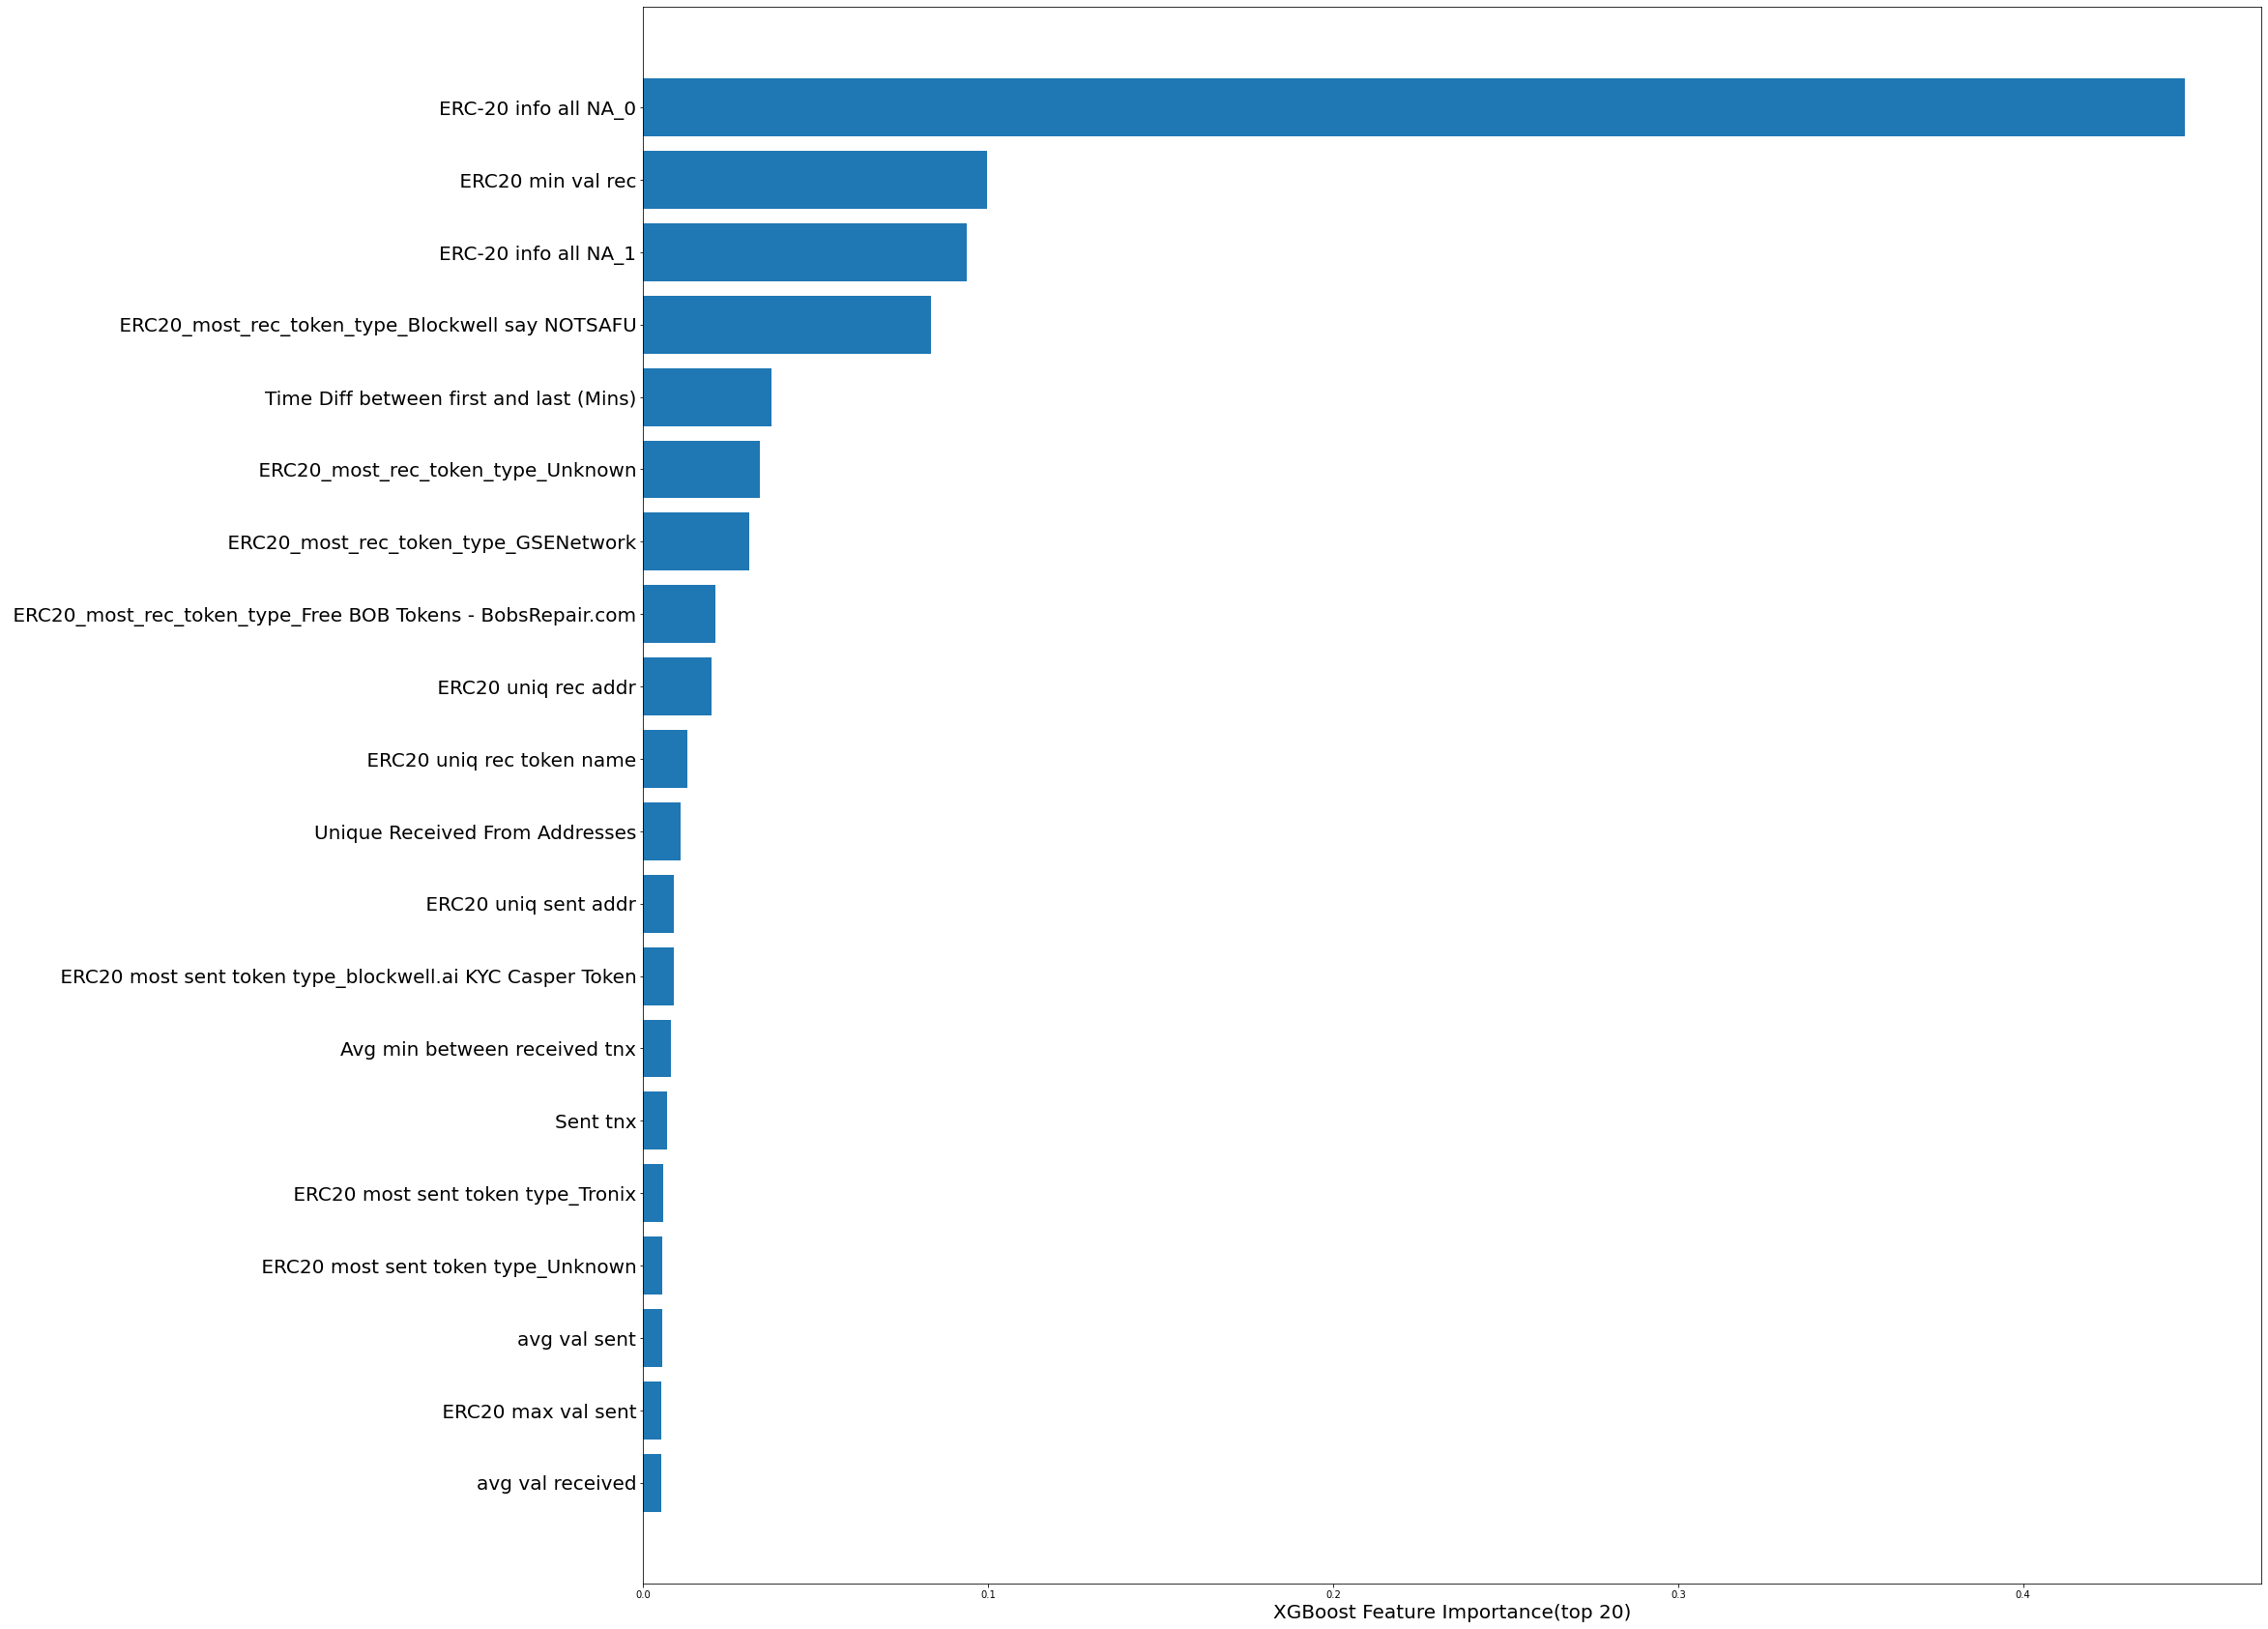

In [83]:
fig, axes = plt.subplots(figsize=(30,30))
plt.barh(importance['features'][::-1],importance['weights'][::-1])
plt.xlabel("XGBoost Feature Importance(top 20)", fontdict={'size':20})
plt.yticks(font={'size':20})
plt.show()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


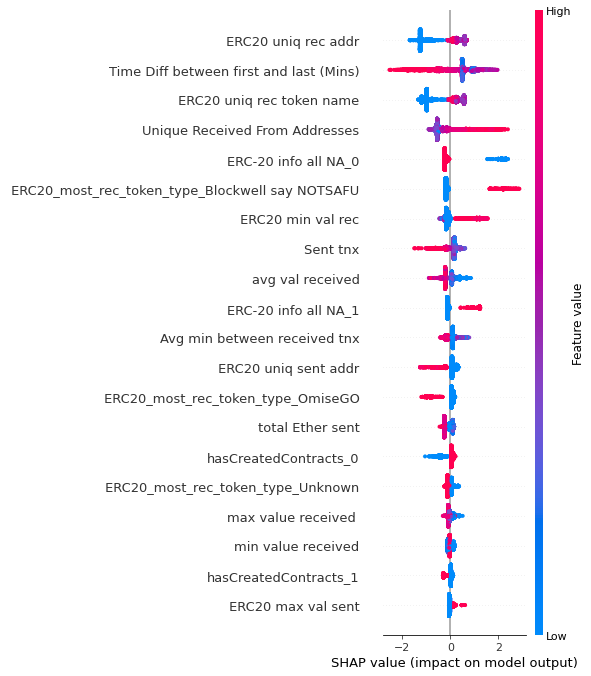

In [84]:
import shap
explainer = shap.TreeExplainer(xgb2)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)